In [7]:
import string
import random
import sklearn
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import lightgbm as lgbm
import missingno as msno
from sklearn.metrics import RocCurveDisplay, confusion_matrix,accuracy_score,classification_report
from sklearn.preprocessing import LabelBinarizer, StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.utils import shuffle
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.ticker import FuncFormatter
import warnings
warnings.filterwarnings("ignore")
sns.set(color_codes = True)   
sns.set_palette(palette = 'gist_heat', n_colors = 8)
sns.set(style="whitegrid")


In [5]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [51]:
d = pd.read_csv('wine.csv')

In [13]:
d.tail()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
1594            6.2             0.600         0.08             2.0      0.090   
1595            5.9             0.550         0.10             2.2      0.062   
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645         0.12             2.0      0.075   
1598            6.0             0.310         0.47             3.6      0.067   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
1594                 32.0                  44.0  0.99490  3.45       0.58   
1595                 39.0                  51.0  0.99512  3.52       0.76   
1596                 29.0                  40.0  0.99574  3.42       0.75   
1597                 32.0                  44.0  0.99547  3.57       0.71   
1598                 18.0                  42.0  0.99549  3.39       0.66   

      alcohol  quality  
1594     10.5        5  
1595     11.2        6  
1596     11.0        6  
1597     10.2        5  
1598     11.0        6

In [15]:
d.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [17]:
d.shape

(1599, 12)

In [19]:
d.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [57]:
d.duplicated().sum()

240

In [59]:
d = d.drop_duplicates()

In [61]:
d.shape

(1359, 12)

In [63]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1359 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1359 non-null   float64
 1   volatile acidity      1359 non-null   float64
 2   citric acid           1359 non-null   float64
 3   residual sugar        1359 non-null   float64
 4   chlorides             1359 non-null   float64
 5   free sulfur dioxide   1359 non-null   float64
 6   total sulfur dioxide  1359 non-null   float64
 7   density               1359 non-null   float64
 8   pH                    1359 non-null   float64
 9   sulphates             1359 non-null   float64
 10  alcohol               1359 non-null   float64
 11  quality               1359 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 138.0 KB


In [65]:
d.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [67]:
d.quality.value_counts()

quality
5    577
6    535
7    167
4     53
8     17
3     10
Name: count, dtype: int64

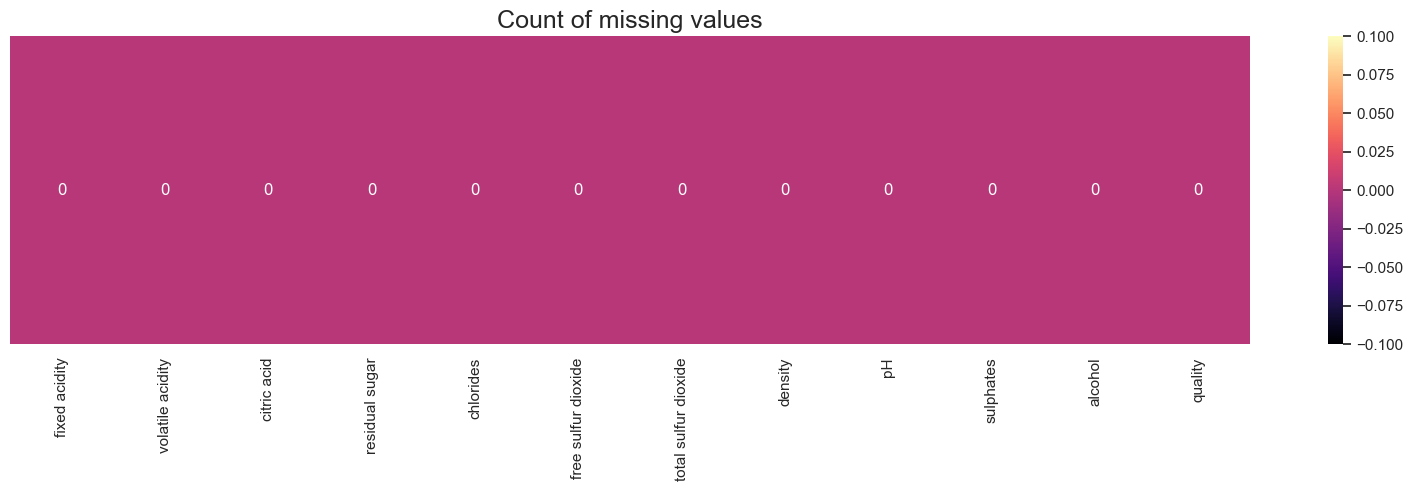

In [127]:
plt.figure(figsize=(20,4))
sns.heatmap(d.isna().sum().to_frame(name='').T, cmap = 'magma', annot = True,
           fmt = '0.0f').set_title('Count of missing values', fontsize = 18)
plt.show()

In [179]:
d.describe().T.style.background_gradient(cmap = 'BuPu', axis = 1)

In [117]:
d.apply(lambda x: len(x.unique()))

fixed acidity            96
volatile acidity        143
citric acid              80
residual sugar           91
chlorides               153
free sulfur dioxide      60
total sulfur dioxide    144
density                 436
pH                       89
sulphates                96
alcohol                  65
quality                   6
dtype: int64

In [145]:
unique = d.nunique().sort_values()
uv = d.apply(lambda x: x.unique())
puv = pd.DataFrame({'Number of unique values': unique, 'Unique values': uv})
puv


Number of unique values  \
alcohol                                    65   
chlorides                                 153   
citric acid                                80   
density                                   436   
fixed acidity                              96   
free sulfur dioxide                        60   
pH                                         89   
quality                                     6   
residual sugar                             91   
sulphates                                  96   
total sulfur dioxide                      144   
volatile acidity                          143   

                                                          Unique values  
alcohol               [9.4, 9.8, 10.0, 9.5, 10.5, 9.2, 9.9, 9.1, 9.3...  
chlorides             [0.076, 0.098, 0.092, 0.075, 0.069, 0.065, 0.0...  
citric acid           [0.0, 0.04, 0.56, 0.06, 0.02, 0.36, 0.08, 0.29...  
density               [0.9978, 0.9968, 0.997, 0.998, 0.9964, 0.9946,...  
fixed acidity         [7.4, 7.8, 11.2, 7.9, 7.3, 7.5, 6.7, 5.6, 8.9,...  
free sulfur dioxide   [11.0, 25.0, 15.0, 17.0, 13.0, 9.0, 16.0, 52.0...  
pH                    [3.51, 3.2, 3.26, 3.16, 3.3, 3.39, 3.36, 3.35,...  
quality                                              [5, 6, 7, 4, 8, 3]  
residual sugar        [1.9, 2.6, 2.3, 1.8, 1.6, 1.2, 2.0, 6.1, 3.8, ...  
sulphates             [0.56, 0.68, 0.65, 0.58, 0.46, 0.47, 0.57, 0.8...  
total sulfur dioxide  [34.0, 67.0, 54.0, 60.0, 40.0, 59.0, 21.0, 18....  
volatile acidity      [0.7, 0.88, 0.76, 0.28, 0.66, 0.6, 0.65, 0.58,...

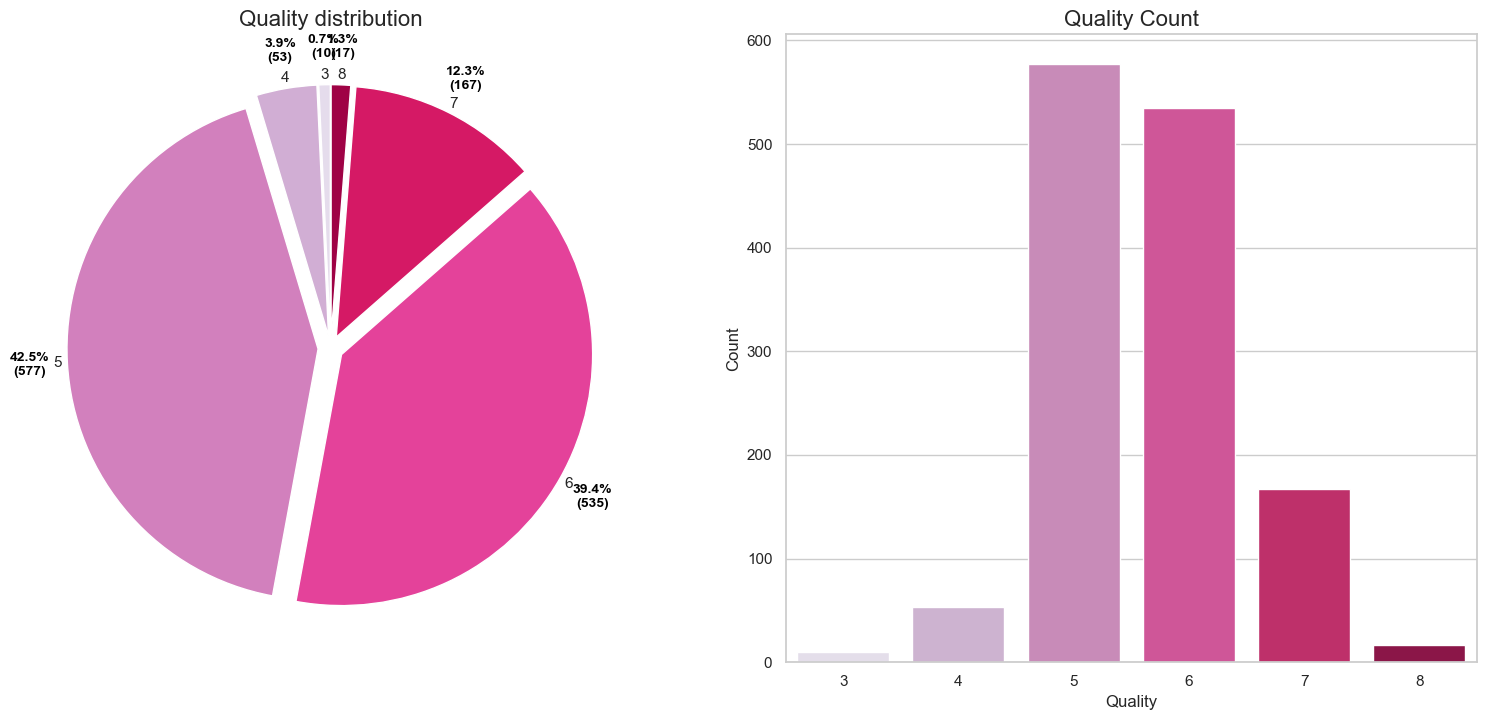

In [173]:
def autopct_outside(pct, values):
    total = sum(values)
    val = int(round(pct*total / 100.0))
    return f'{pct:.1f}%\n({val})'
plt.figure(figsize=(16,8))
plt.subplot(121)
quality_counts = d['quality'].value_counts().sort_index()
explode = [0.05]*len(quality_counts)

wedges,texts,autotexts = plt.pie(quality_counts,labels = quality_counts.index, 
                                 colors = sns.color_palette('PuRd', len(quality_counts)),
                                 autopct = lambda pct: autopct_outside(pct, quality_counts),
                                 startangle = 90, explode = explode, pctdistance = 1.15,
                                 labeldistance = 1.04)
for i in texts:
    i.set_horizontalalignment('center')
for j in autotexts:
    j.set_color('black')
    j.set_fontsize(10)
    j.set_weight('bold')
plt.title('Quality distribution', fontsize = 16)

plt.subplot(122)
sns.countplot(data = d, x='quality', palette = 'PuRd')

plt.title('Quality Count', fontsize=16)
plt.xlabel('Quality', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()    

<Axes: >

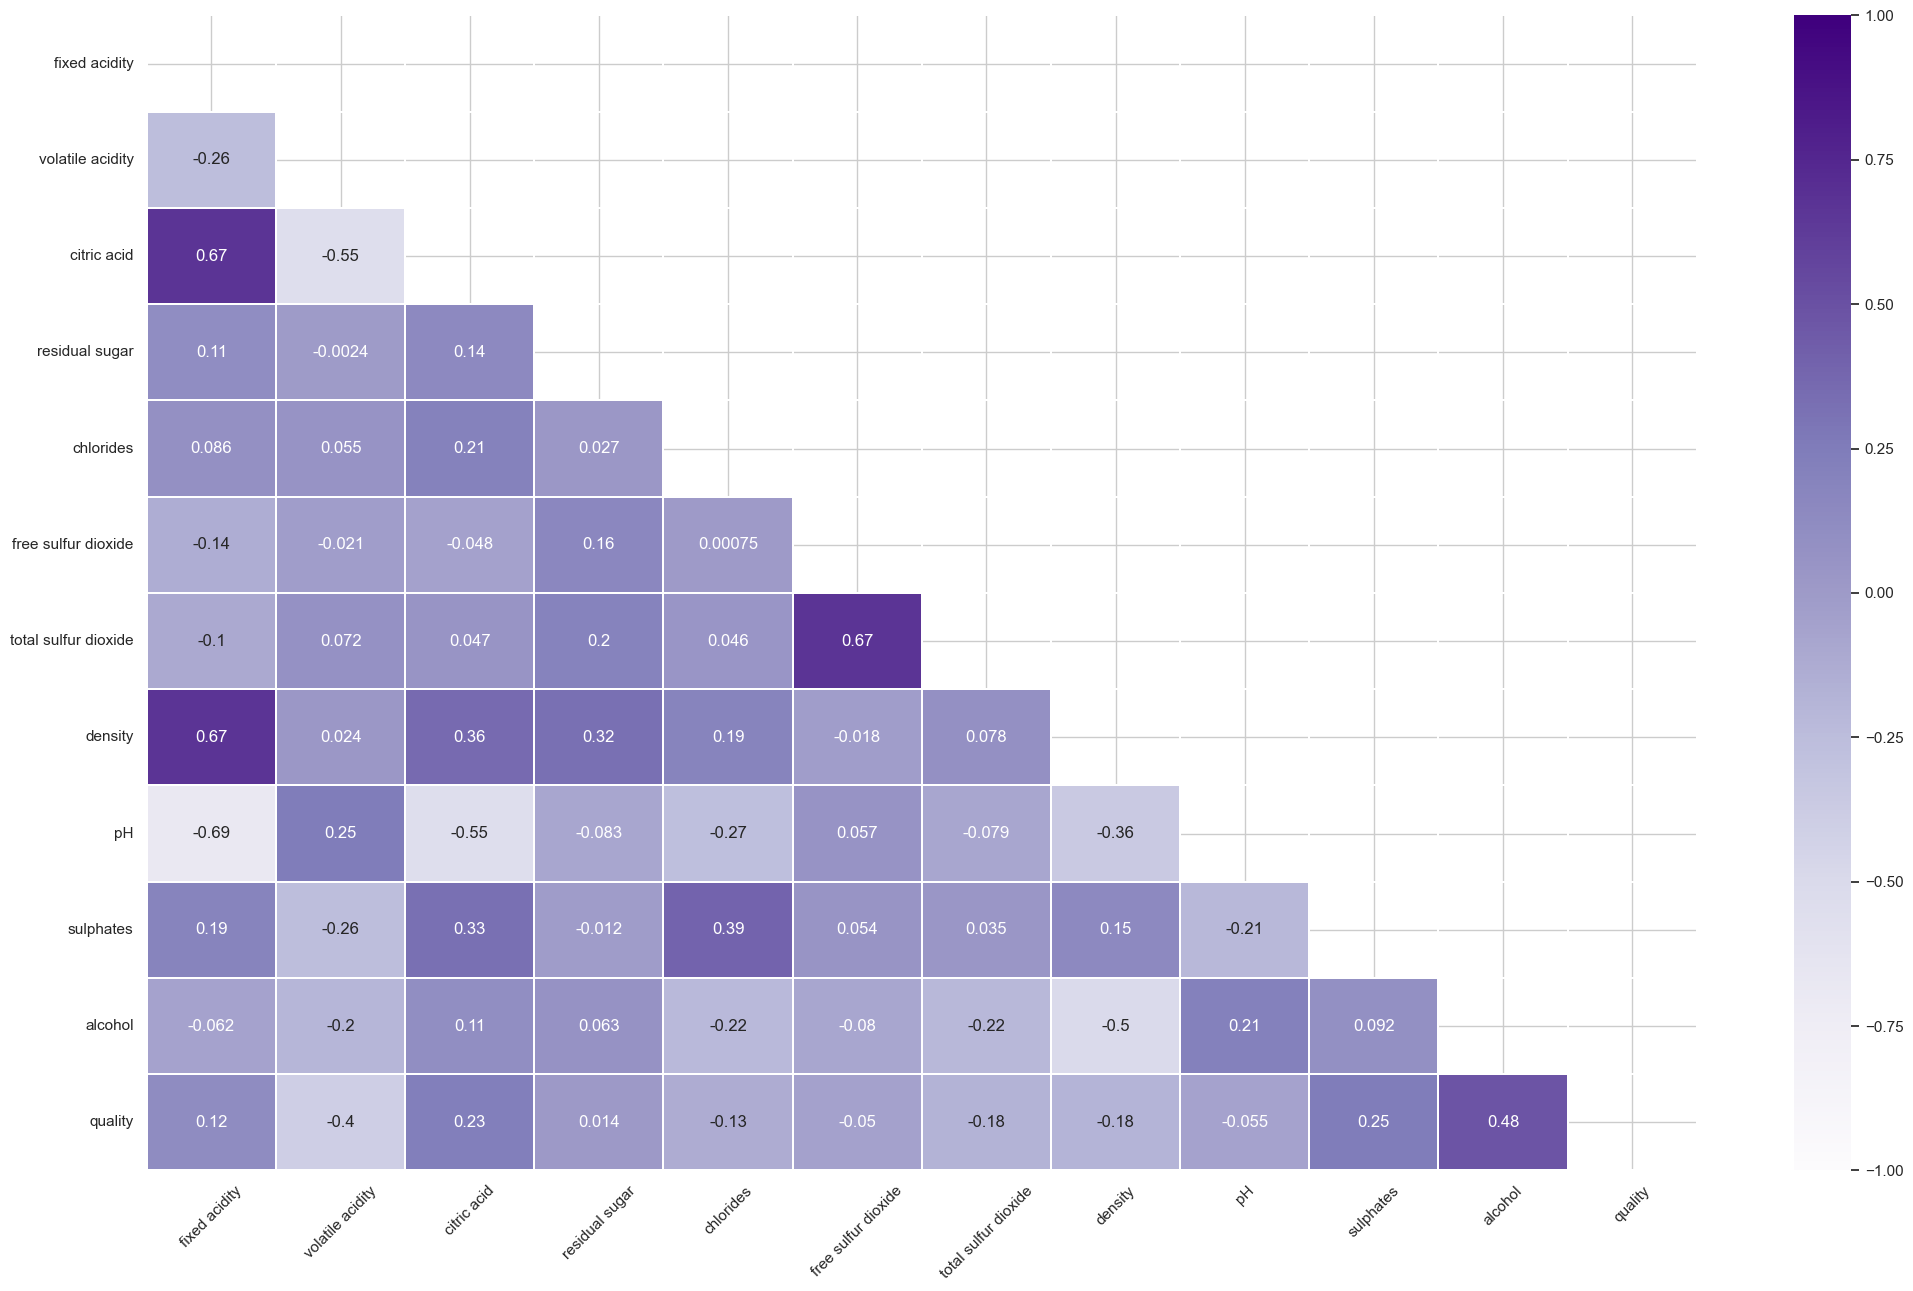

In [195]:
plt.figure(figsize=(25,15))
corr = d.corr()
corr = corr.fillna(0)
mask = np.triu(np.ones_like(corr,dtype = bool))
plt.xticks(rotation = 45)
plt.yticks(rotation = 90)
sns.heatmap(corr, mask = mask, xticklabels = corr.columns, yticklabels = corr.columns, annot = True, cmap = 'Purples', linewidth = 0.2, vmin = -1, vmax = +1 )

In [197]:
d.corr(numeric_only = True).T.style.background_gradient(cmap = 'magma', axis = 1)

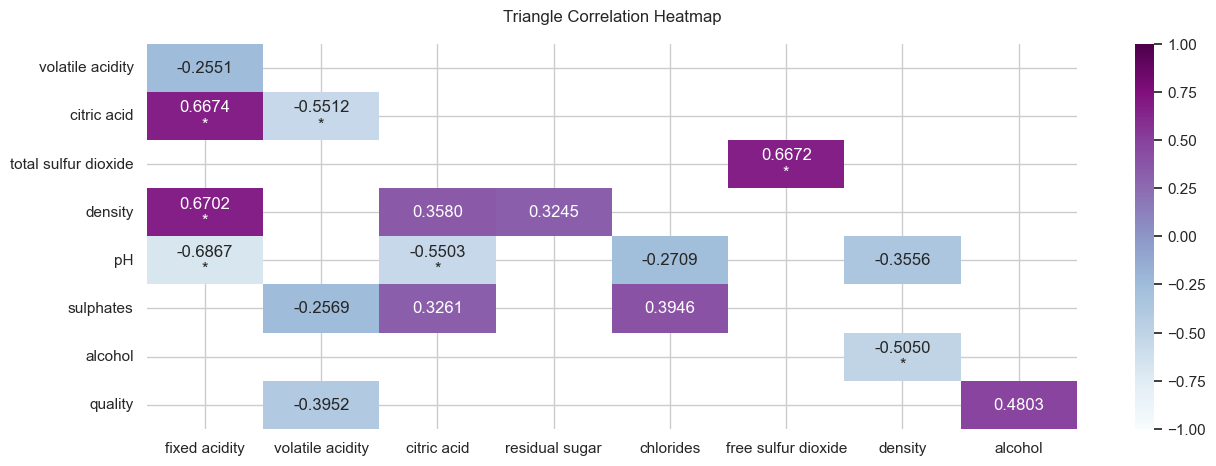

In [220]:
corr = d.corr(numeric_only = True)
f,ax = plt.subplots(figsize=(15,5))
mask = np.triu(np.ones_like(corr,dtype = bool))
cut_off = 0.25
extreme_1 = 0.5
extreme_2 = 0.75
extreme_3 = 0.9
mask |= np.abs(corr) < cut_off
corr = corr[~mask]
remove_empty_rows_and_cols = True
if remove_empty_rows_and_cols:
    rows = np.flatnonzero(np.count_nonzero(~mask, axis = 0))
    columns = np.flatnonzero(np.count_nonzero(~mask, axis = 1))
    corr = corr.iloc[columns,rows]

annot = [[f'{val:.4f}' 
         +('' if abs(val) < extreme_1 else '\n*')
         +('' if abs(val) < extreme_2 else '*')
         +('' if abs(val) < extreme_3 else '*')
         for val in row] for row in corr.to_numpy()]

heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=annot, fmt='', cmap='BuPu')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize': 12}, pad=16)
plt.show()


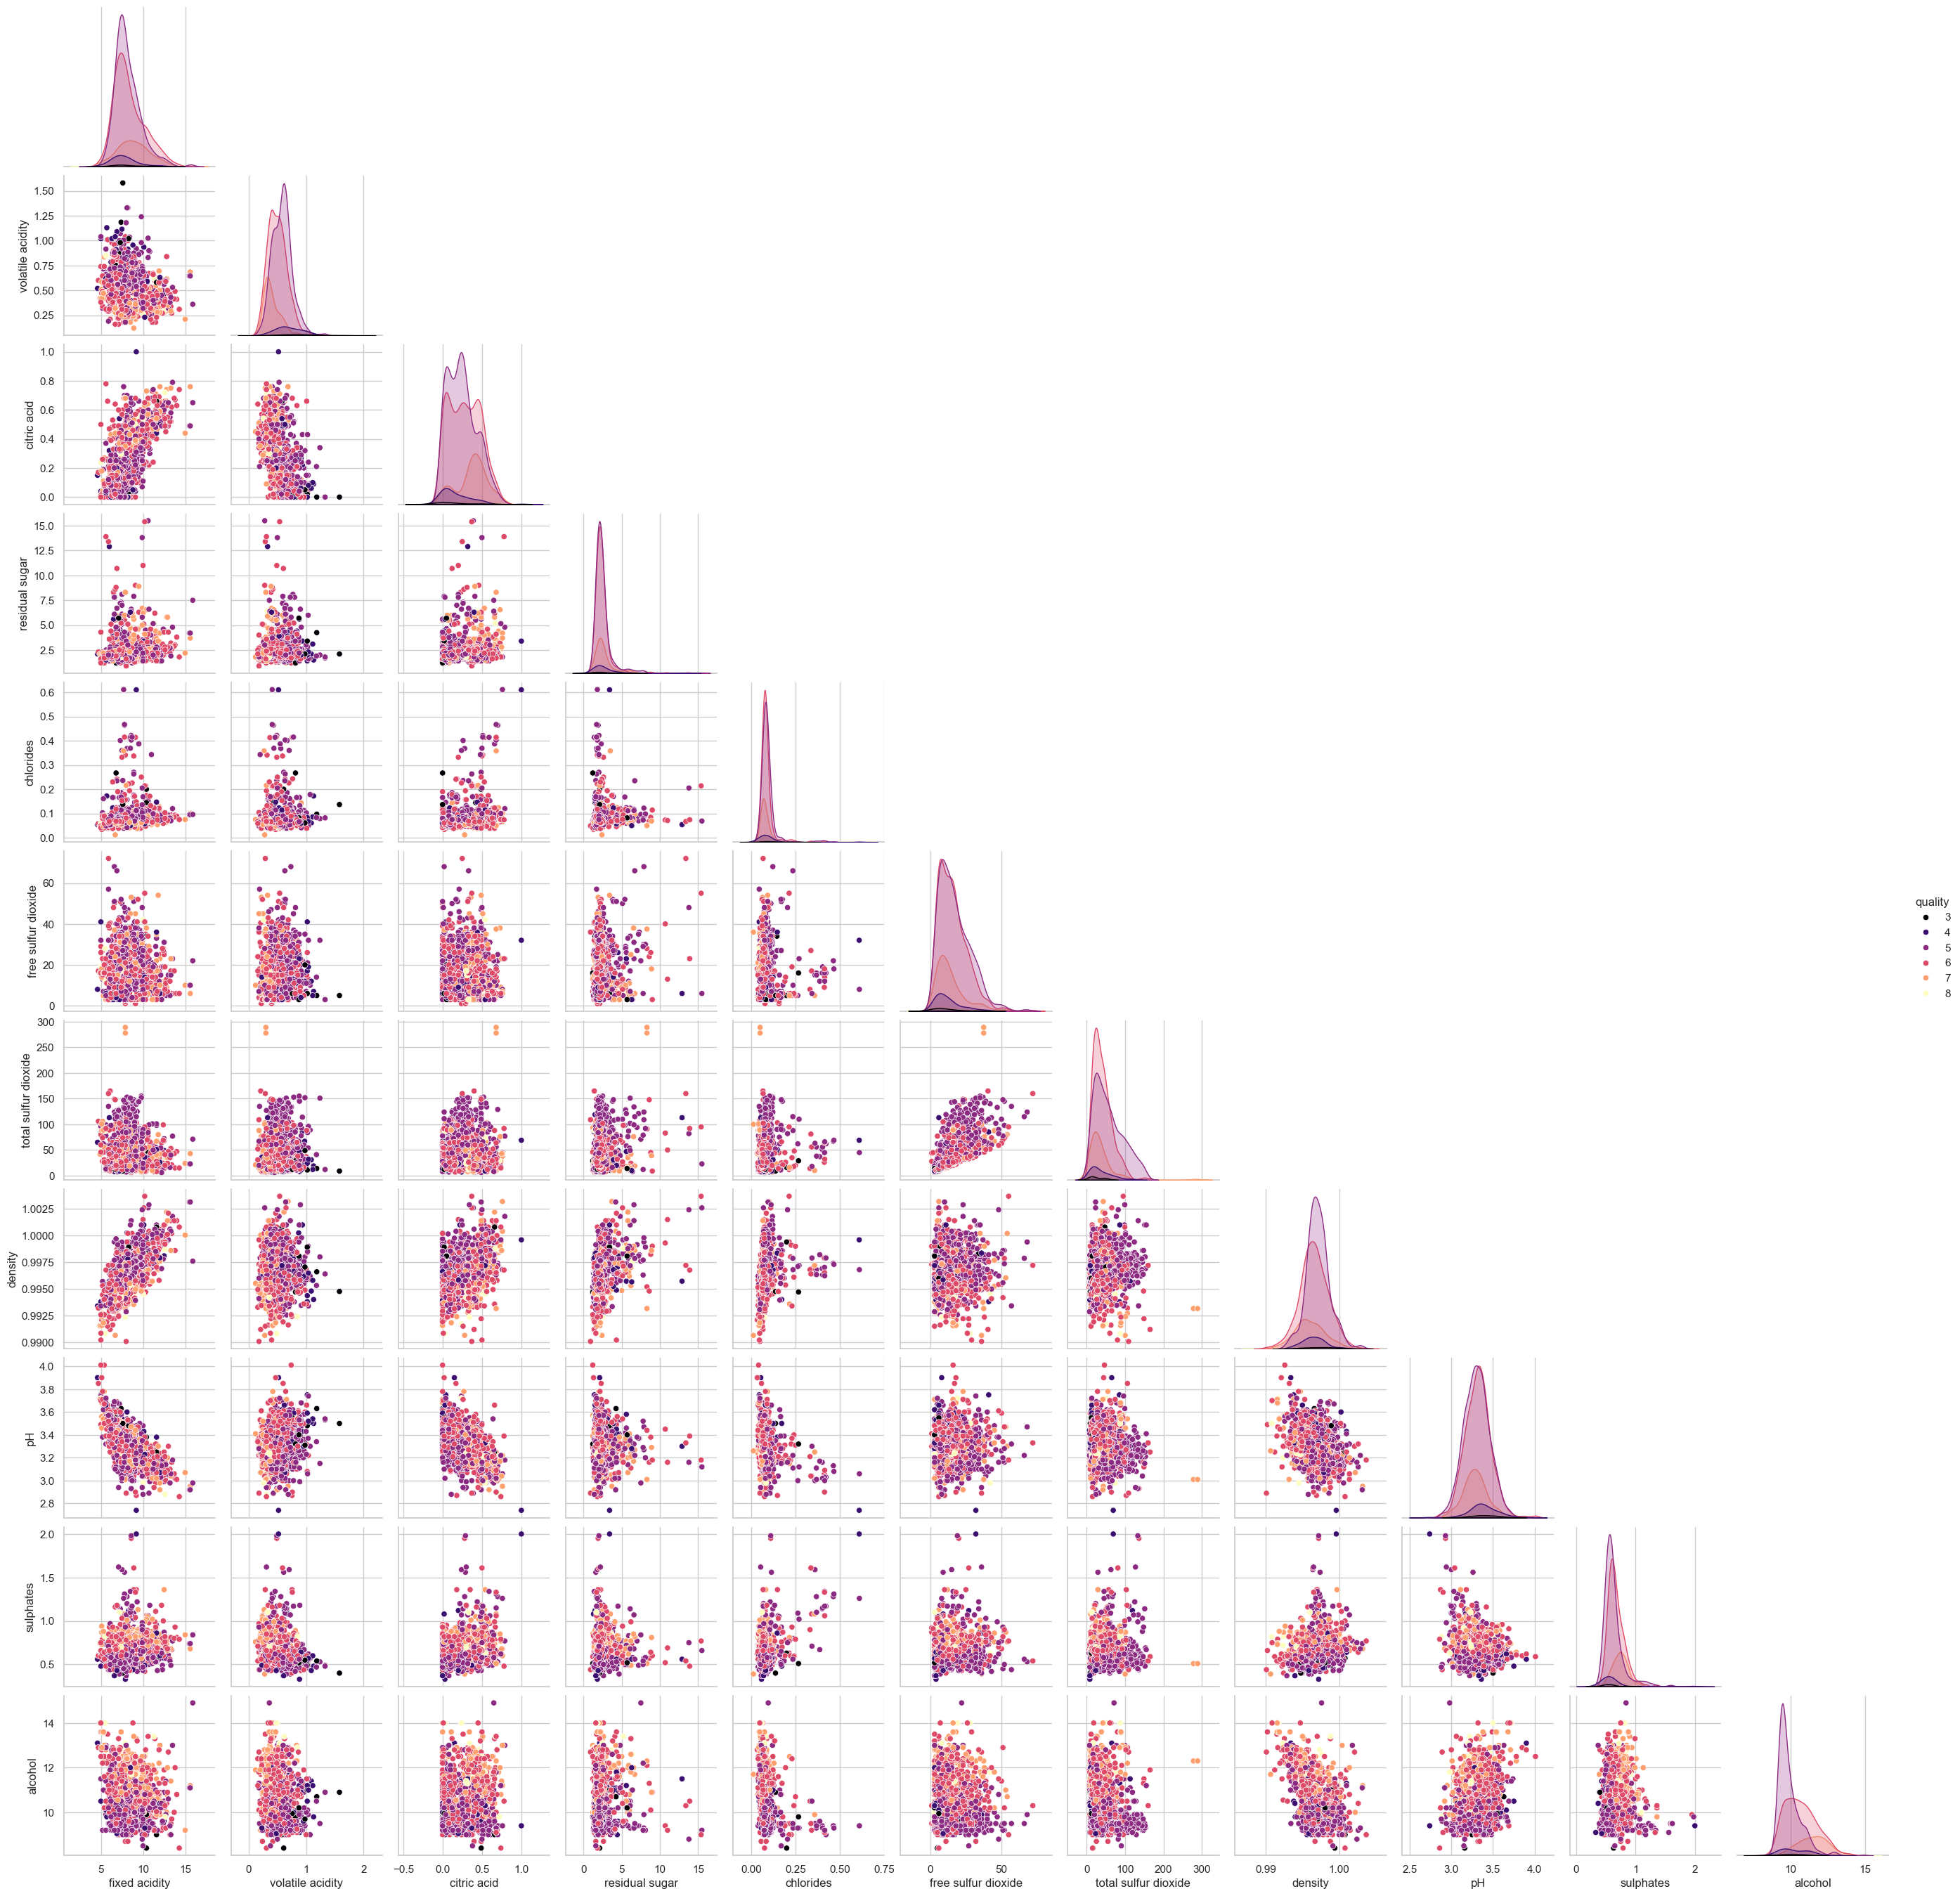

In [217]:
sns.pairplot(d, diag_kind = 'kde', hue = 'quality', palette = 'magma', corner = True)

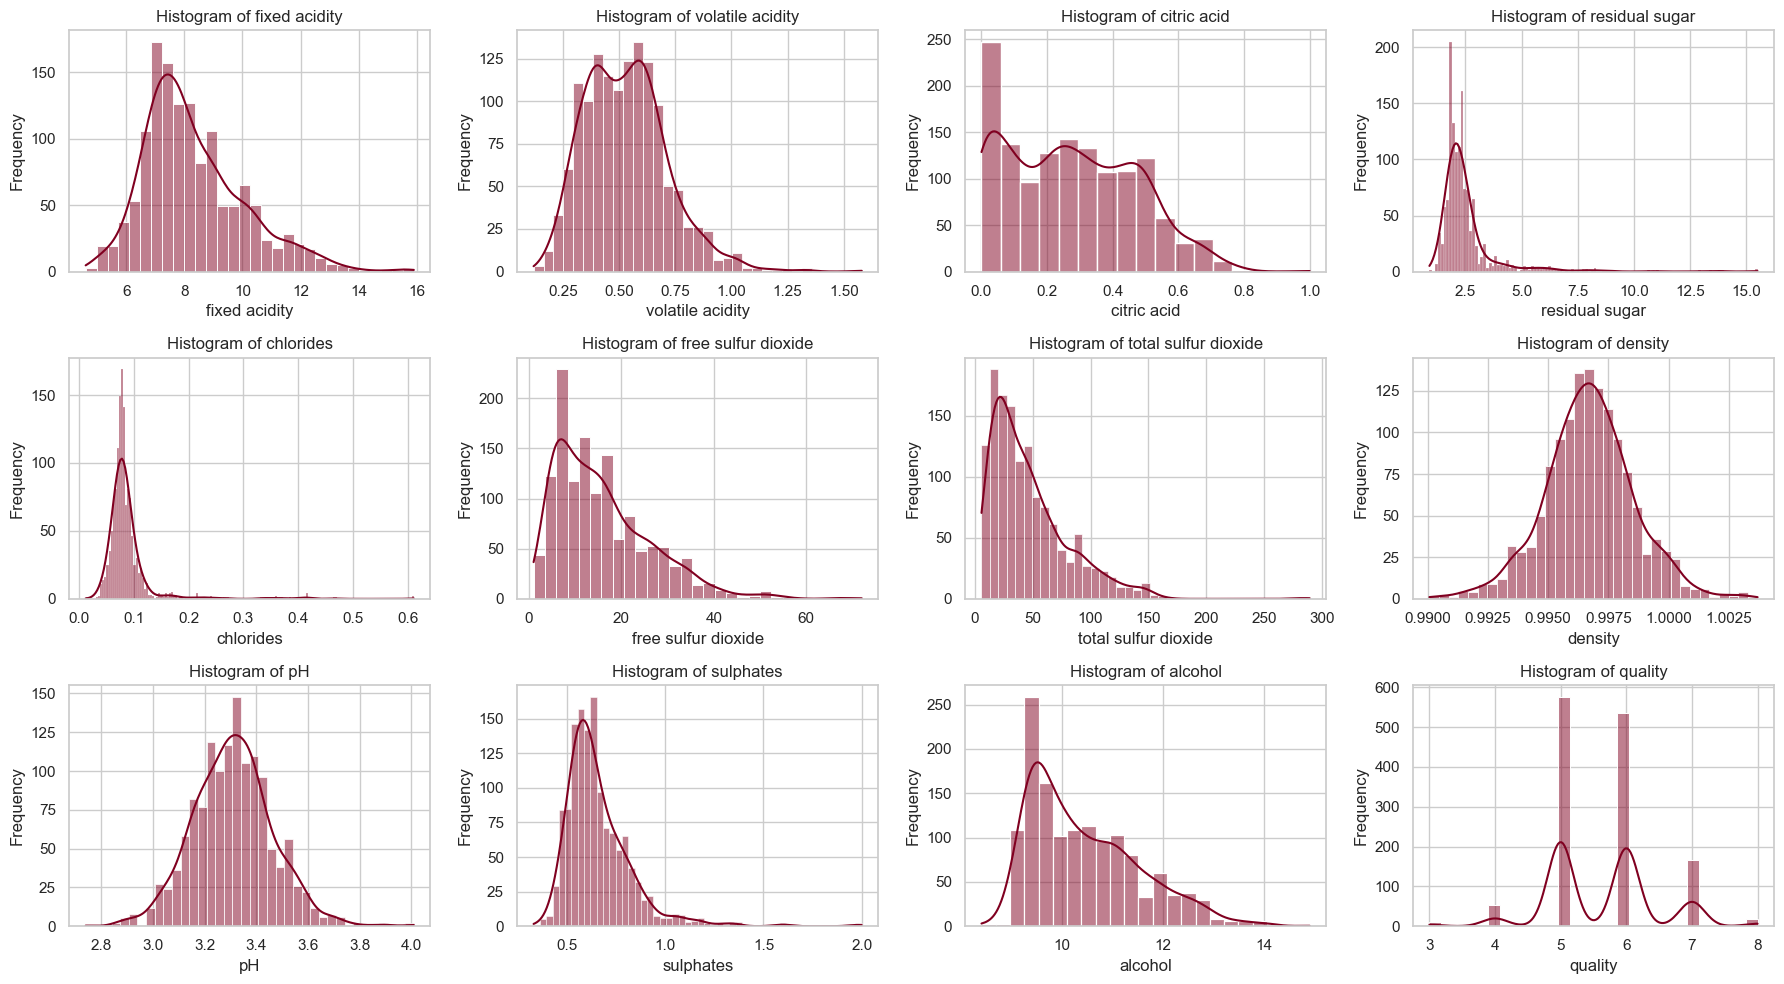

In [240]:
f = list(d.columns)
fig,axes = plt.subplots(3,4,figsize=(18,10))
for i, column in enumerate(f):
    ax = axes[i // 4, i%4]
    sns.histplot(d[column],kde = True, color = '#800020', ax = ax, palette = 'Purples')
    ax.set_title(f'Histogram of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()


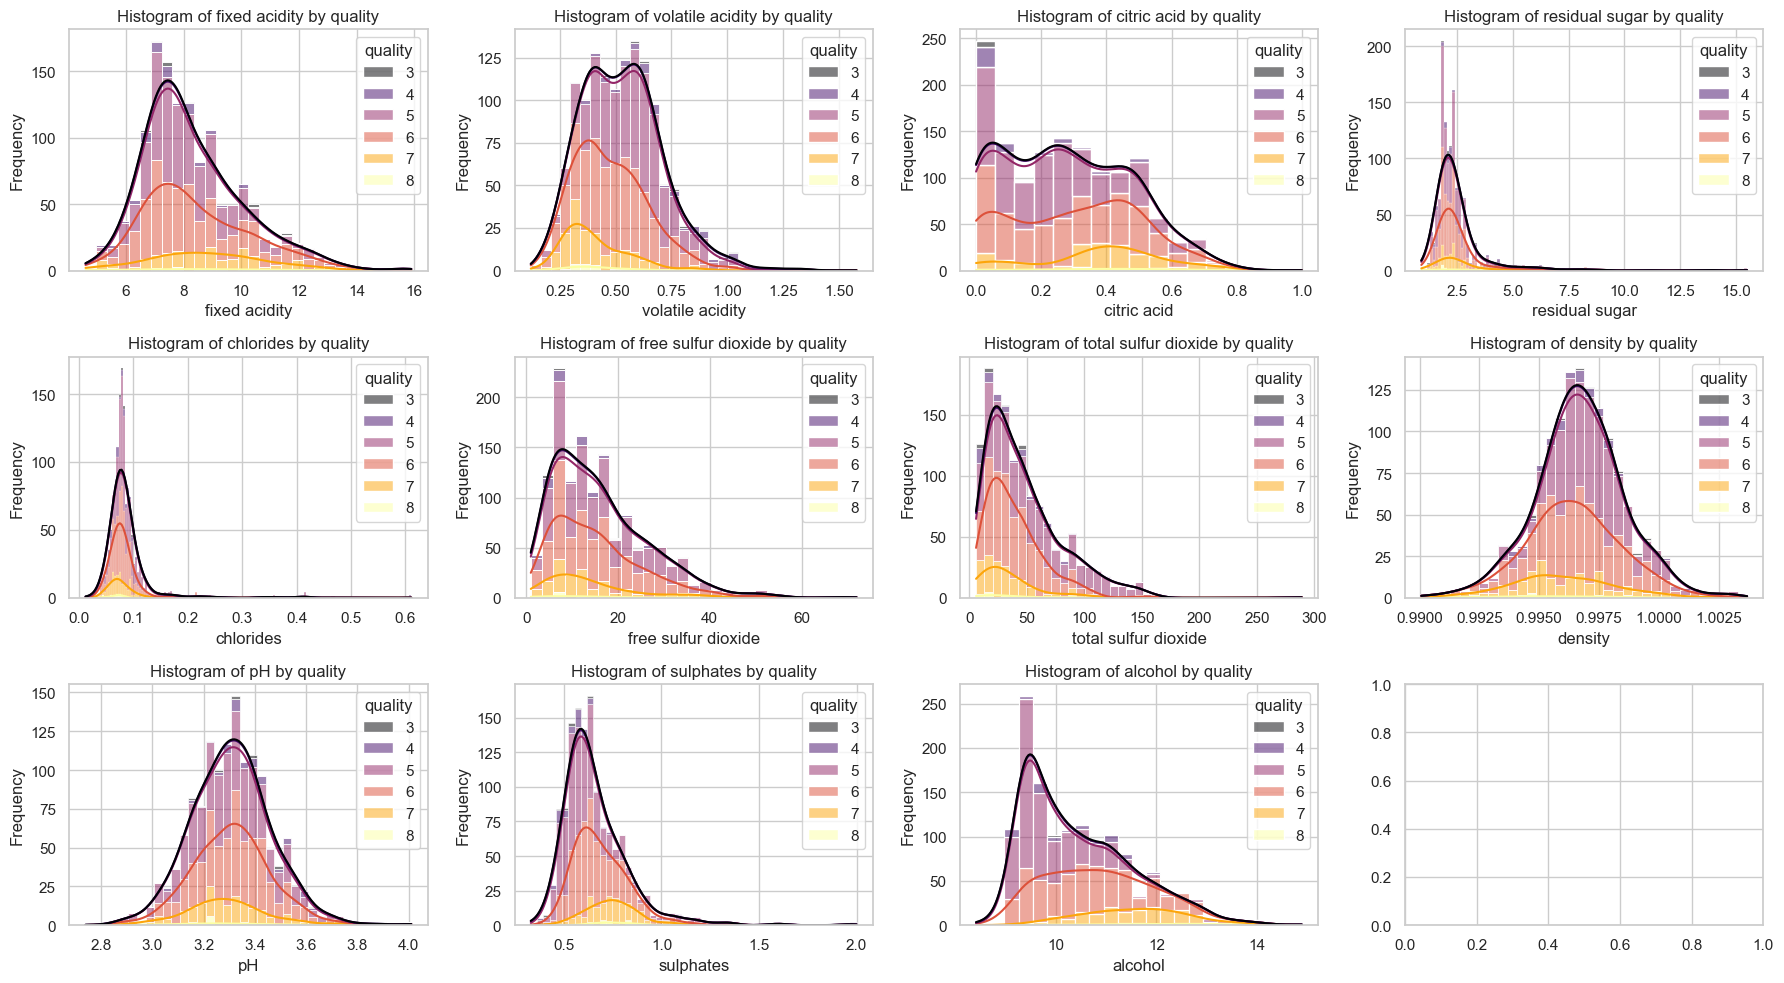

In [250]:
fig,axes = plt.subplots(3,4,figsize=(18,10))
for i, column in enumerate(f[:-1]):
    ax = axes[i // 4, i%4]
    sns.histplot(d, x = column, hue = 'quality',kde = True, ax = ax, palette = 'inferno', multiple = 'stack')
    ax.set_title(f'Histogram of {column} by quality')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()


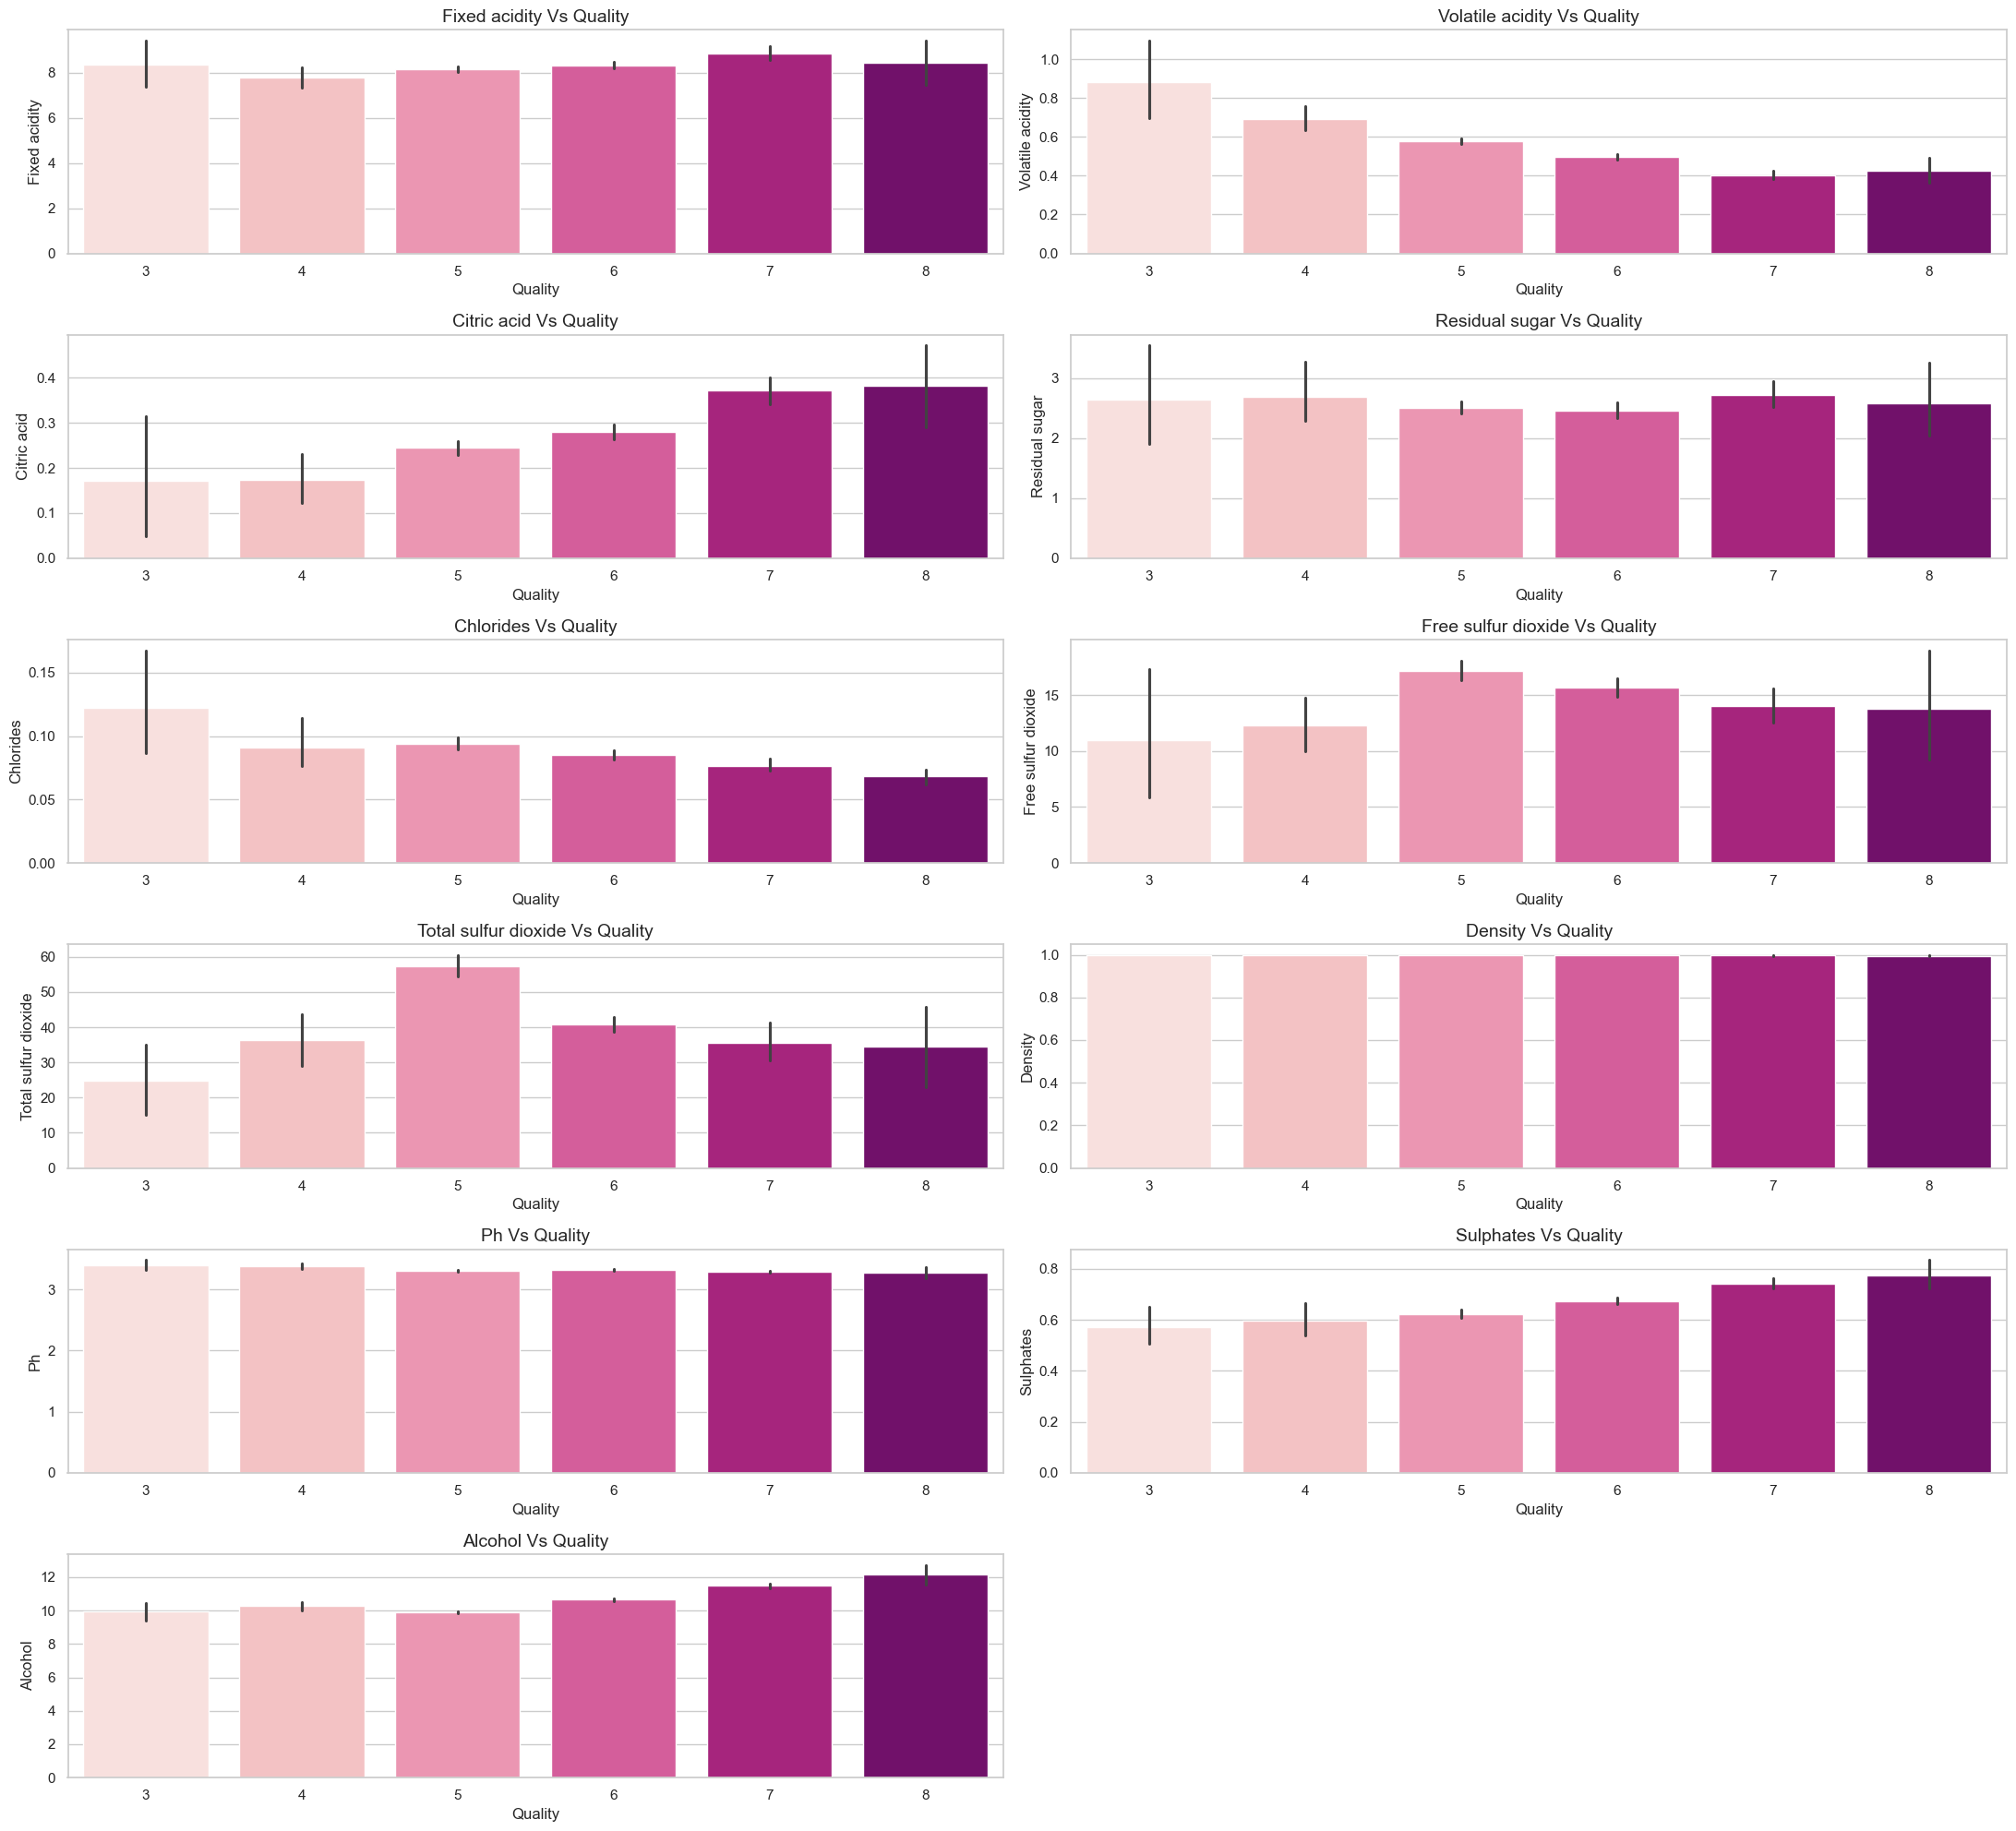

In [264]:
plt.figure(figsize=(22,20))
col = list(d.columns)
for i in range(1,12):
    plt.subplot(6,2,i)
    sns.barplot(d, x = 'quality', y = col[i-1],  palette = 'RdPu')
    plt.title(f'{col[i-1].capitalize()} Vs Quality', fontsize = 14)
    plt.xlabel('Quality', fontsize = 12)
    plt.ylabel(col[i-1].capitalize(),fontsize = 12)
plt.tight_layout()
plt.show()

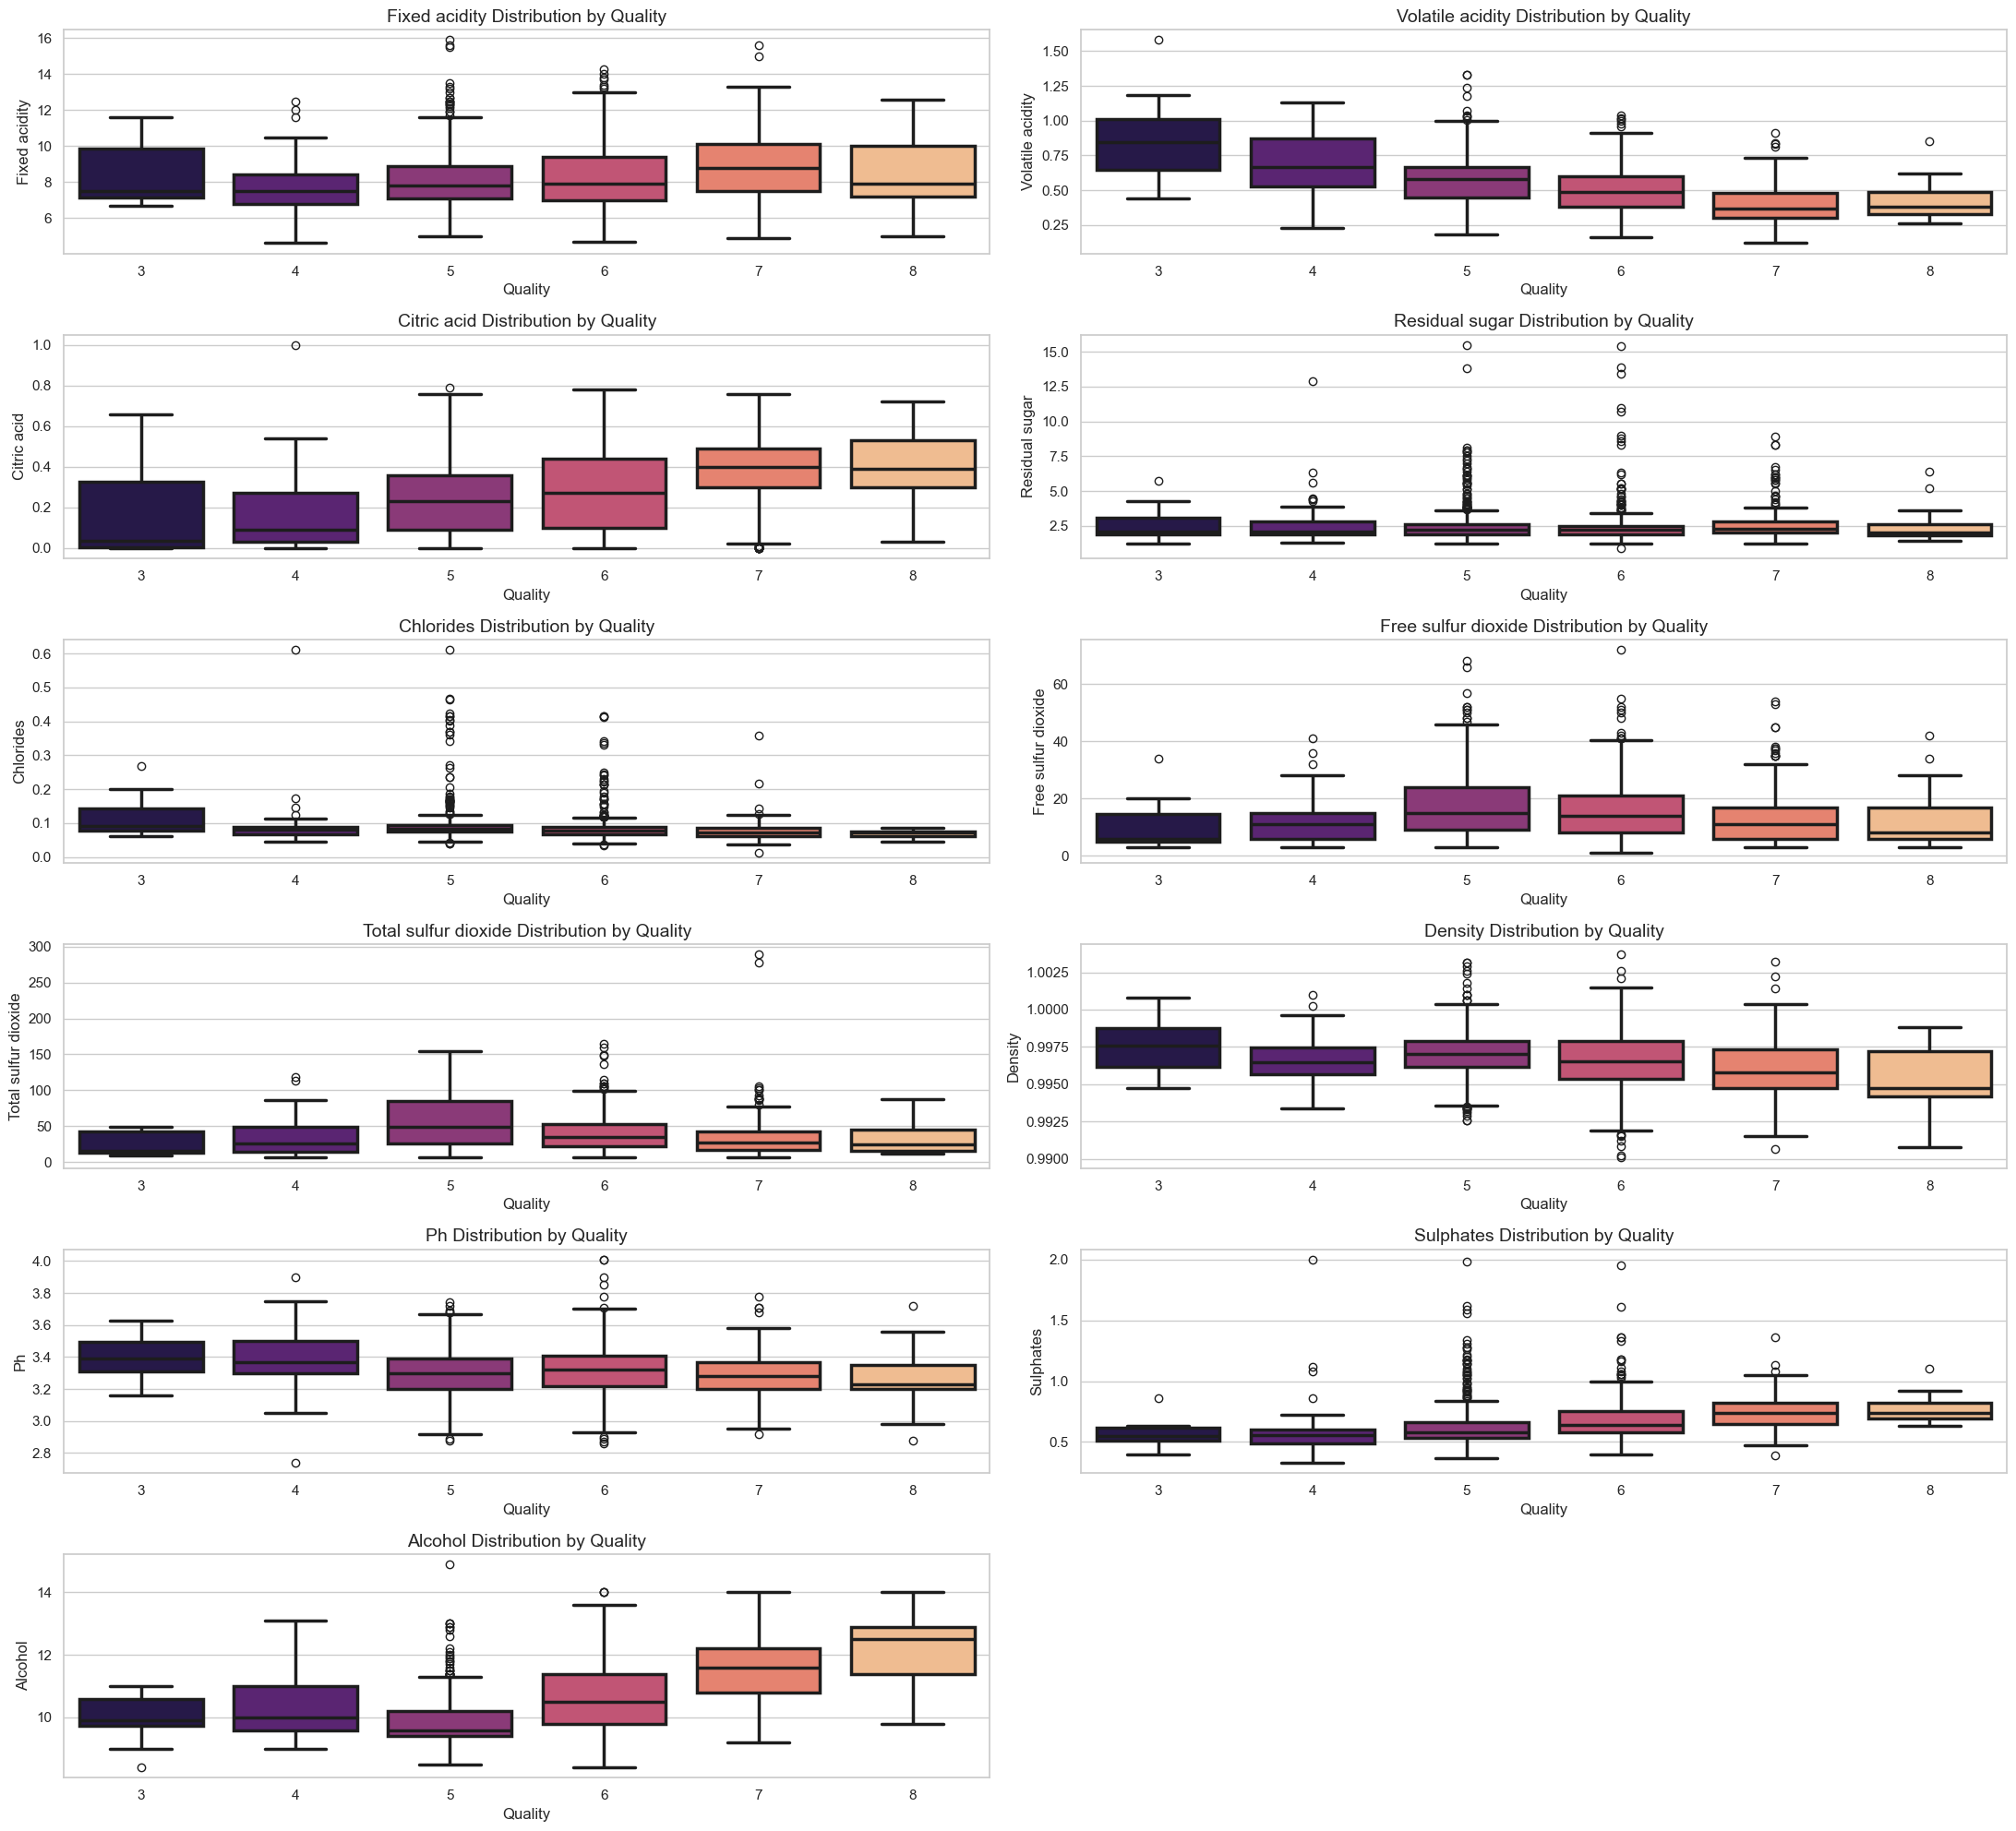

In [272]:
plt.figure(figsize=(22,20))
col = list(d.columns)
for i in range(1,12):
    plt.subplot(6,2,i)
    sns.boxplot(d, x = 'quality', y = col[i-1],  palette = 'magma', linewidth = 2.5, fliersize =6)
    plt.title(f'{col[i-1].capitalize()} Distribution by Quality', fontsize = 14)
    plt.xlabel('Quality', fontsize = 12)
    plt.ylabel(col[i-1].capitalize(),fontsize = 12)
plt.tight_layout()
plt.show()

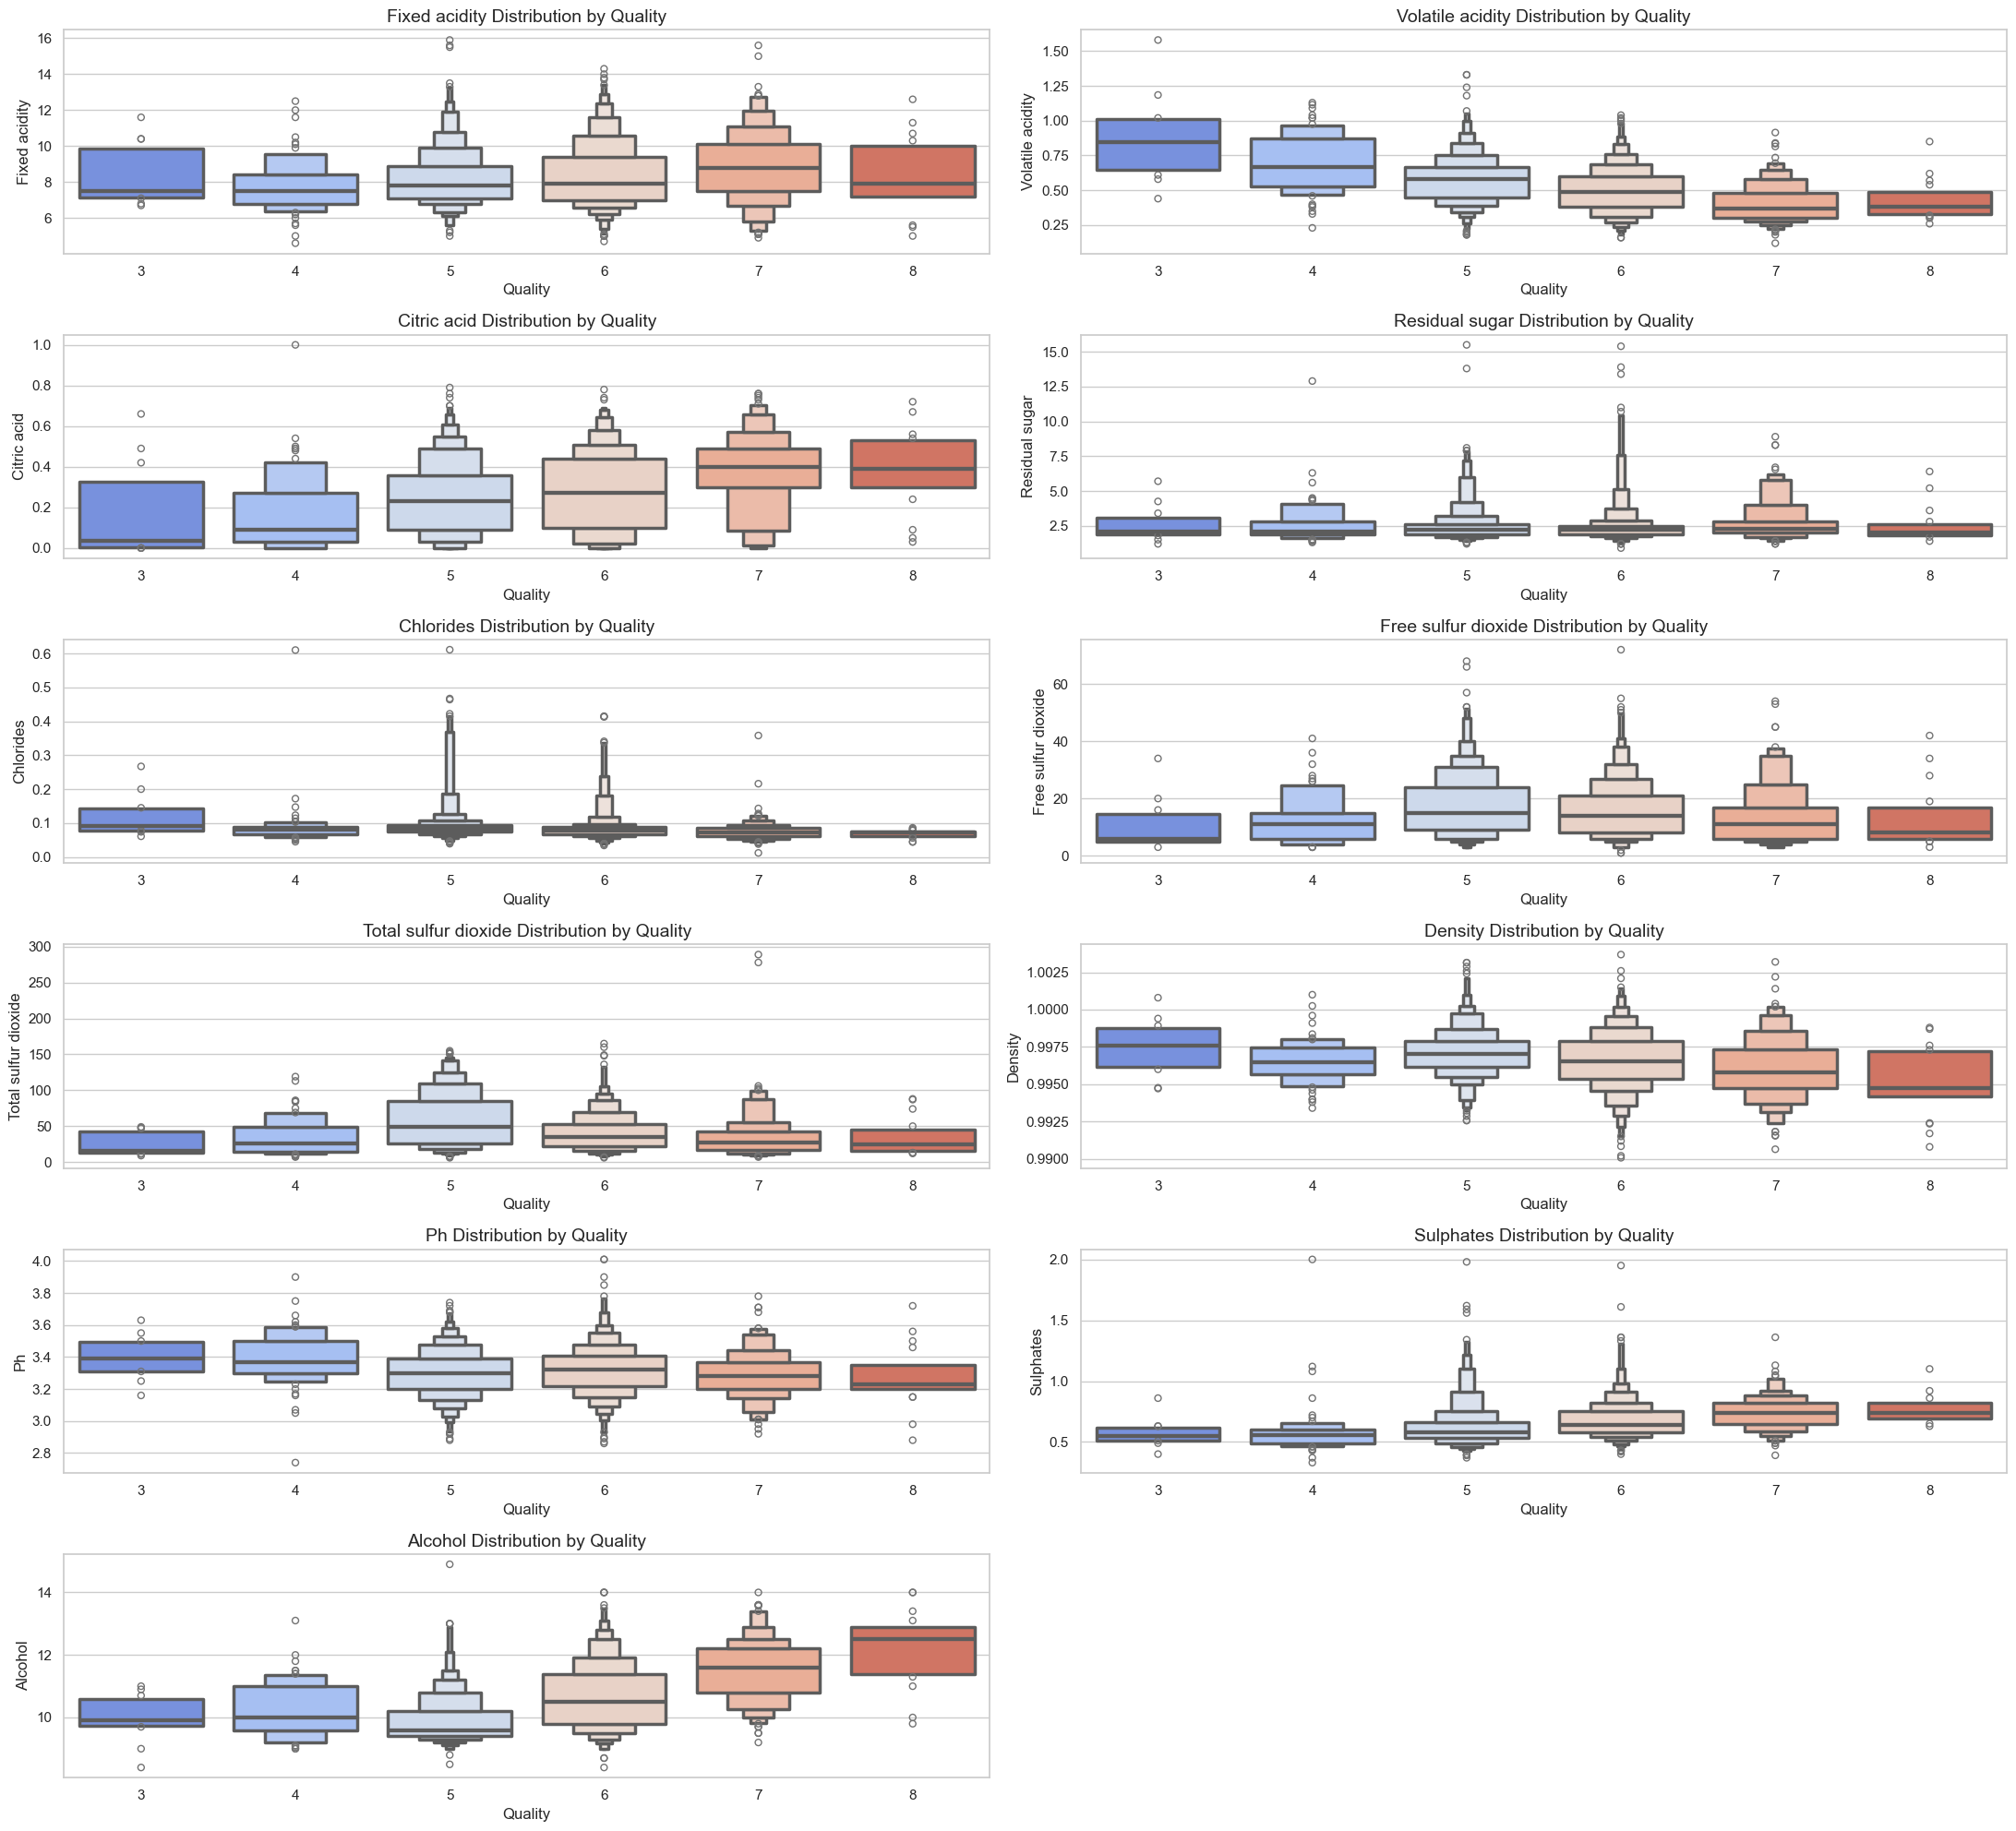

In [276]:
plt.figure(figsize=(22,20))
col = list(d.columns)
for i in range(1,12):
    plt.subplot(6,2,i)
    sns.boxenplot(d, x = 'quality', y = col[i-1],  palette = 'coolwarm', linewidth = 2.5)
    plt.title(f'{col[i-1].capitalize()} Distribution by Quality', fontsize = 14)
    plt.xlabel('Quality', fontsize = 12)
    plt.ylabel(col[i-1].capitalize(),fontsize = 12)
plt.tight_layout()
plt.show()

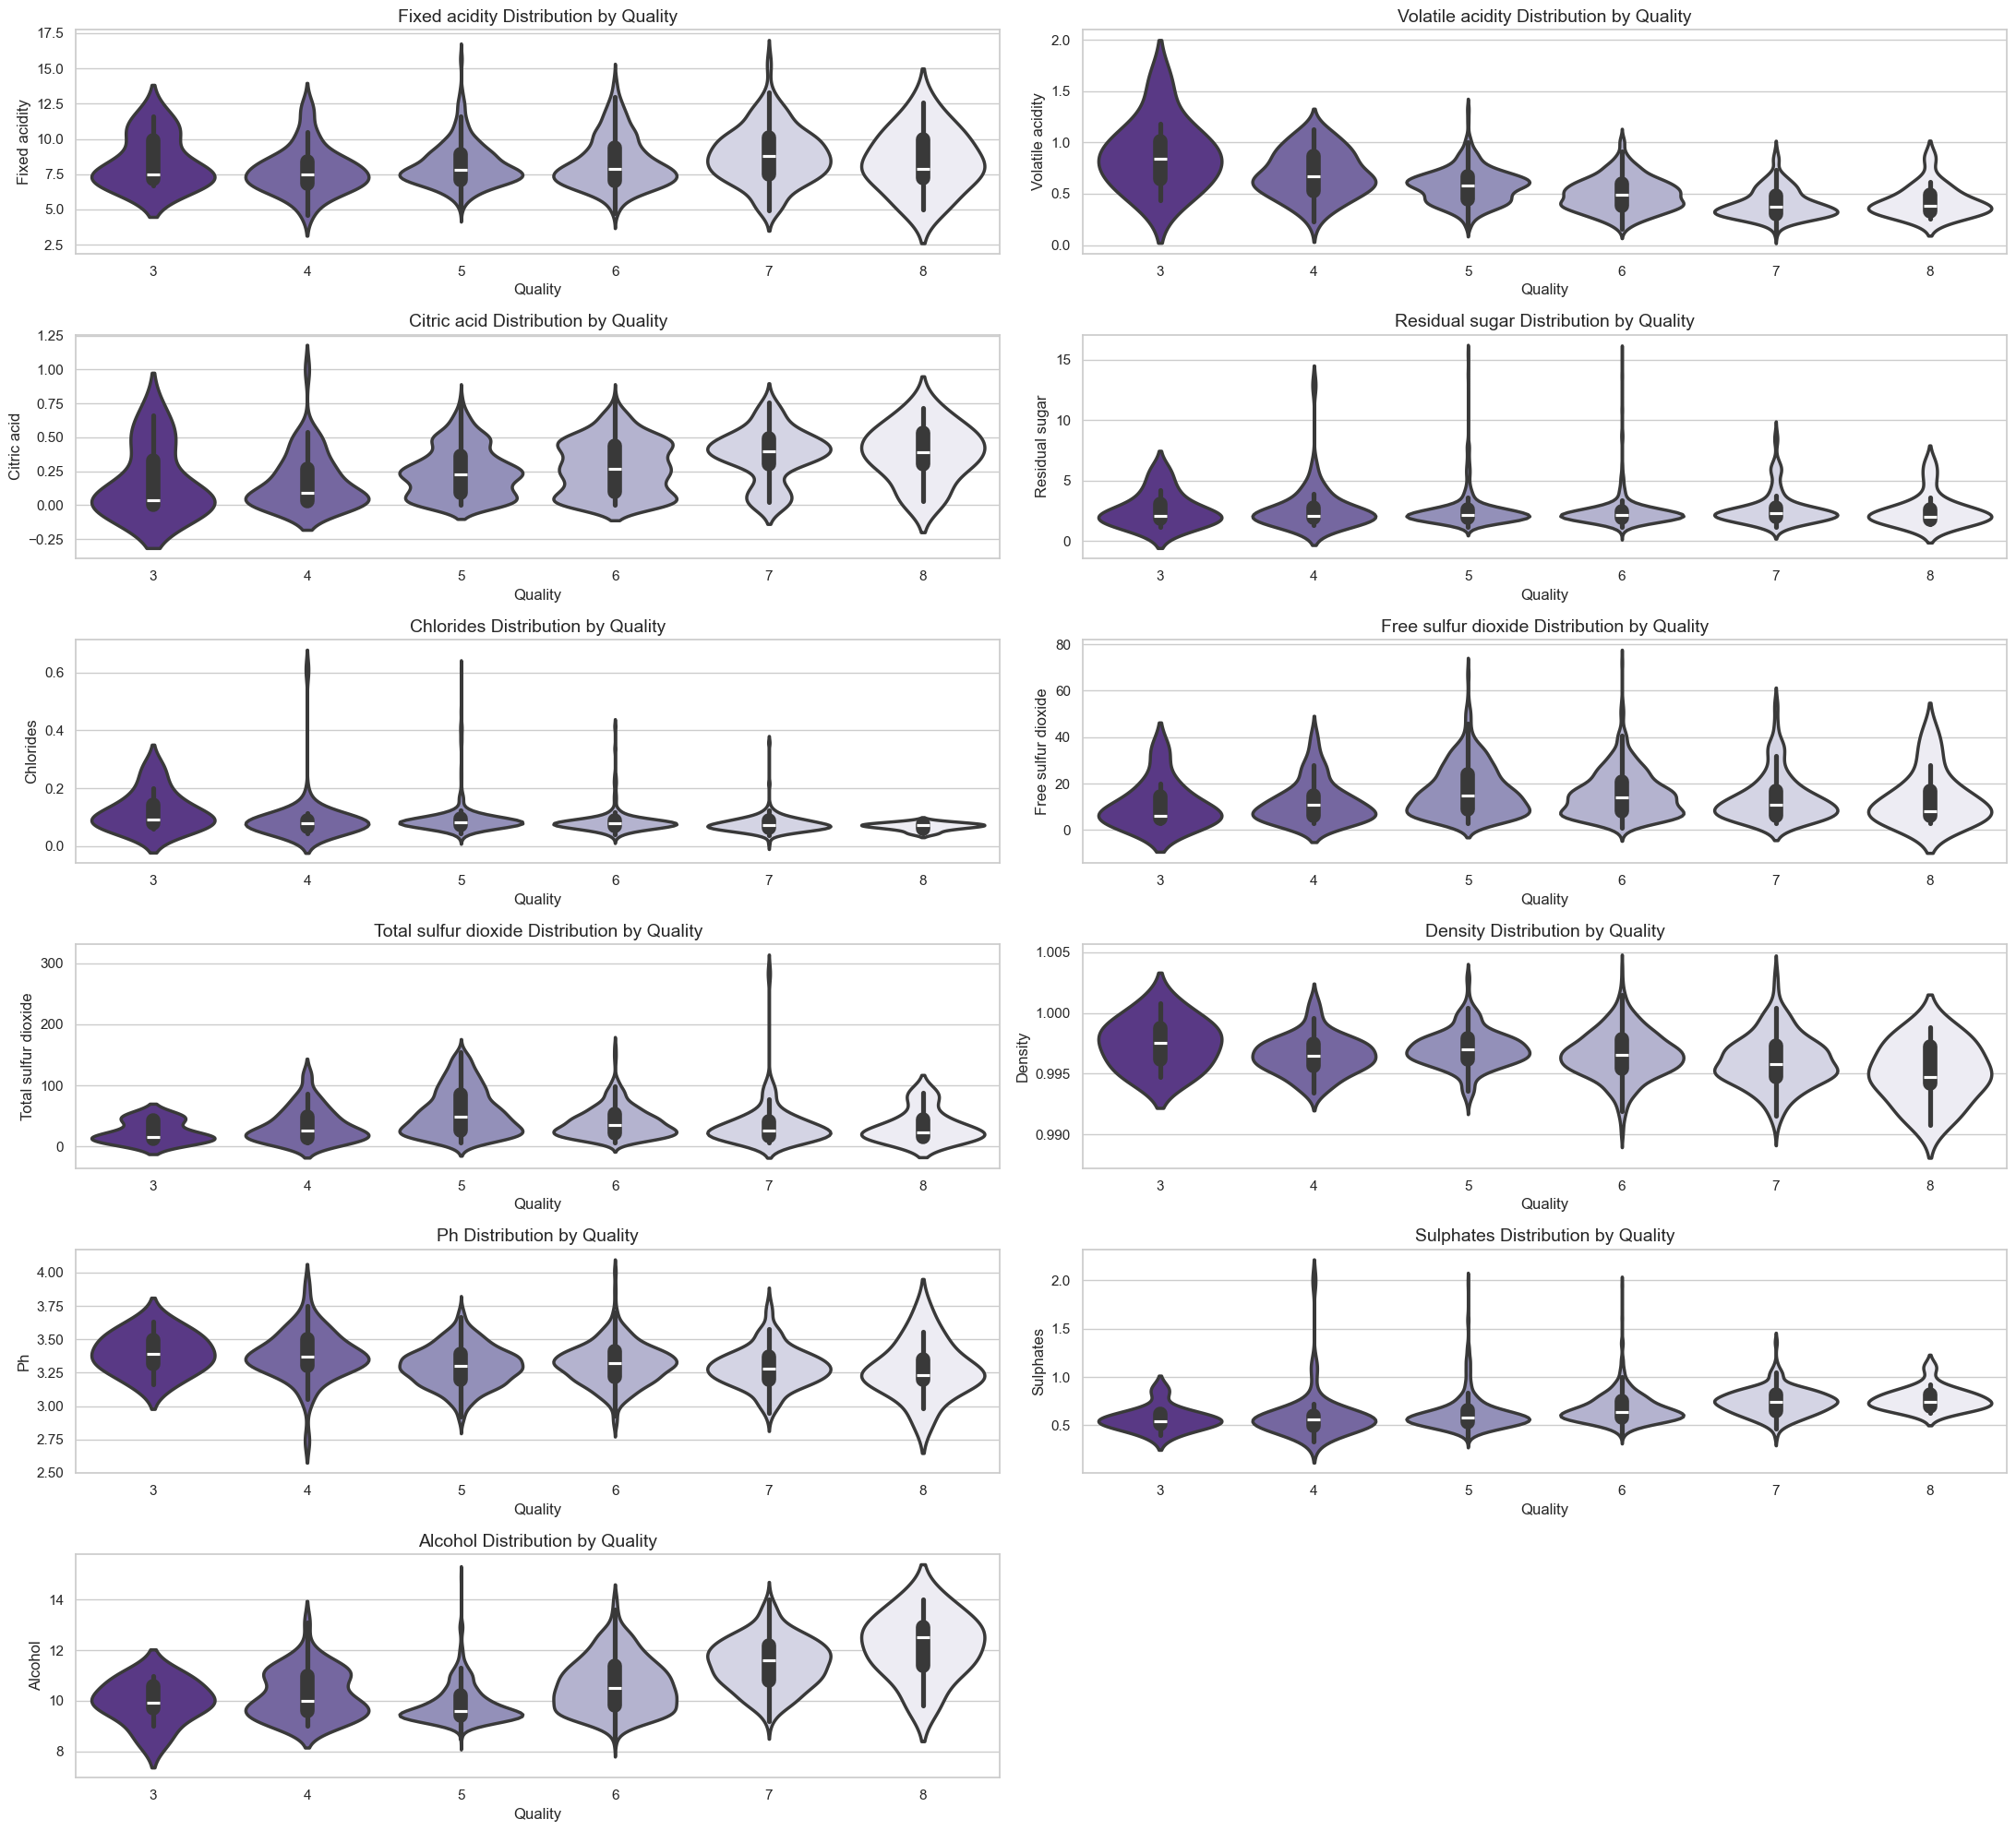

In [282]:
plt.figure(figsize=(22,20))
col = list(d.columns)
for i in range(1,12):
    plt.subplot(6,2,i)
    sns.violinplot(d, x = 'quality', y = col[i-1],  palette = 'Purples_r', linewidth = 2.5)
    plt.title(f'{col[i-1].capitalize()} Distribution by Quality', fontsize = 14)
    plt.xlabel('Quality', fontsize = 12)
    plt.ylabel(col[i-1].capitalize(),fontsize = 12)
plt.tight_layout()
plt.show()

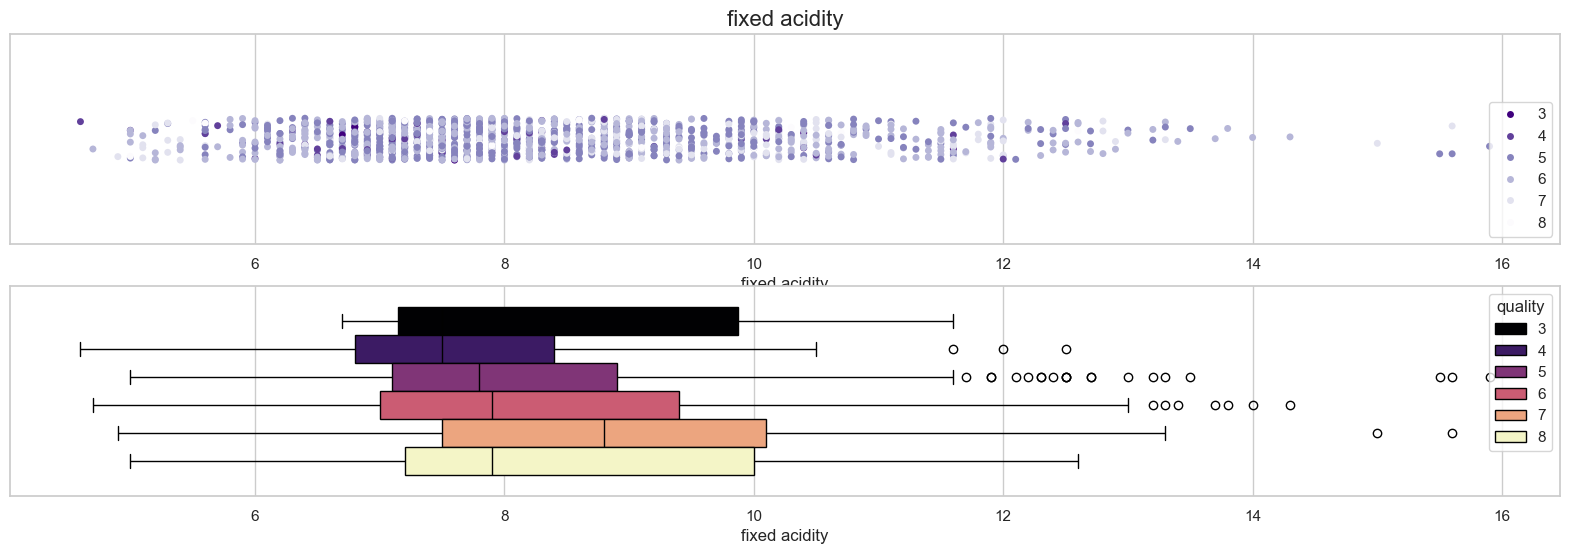

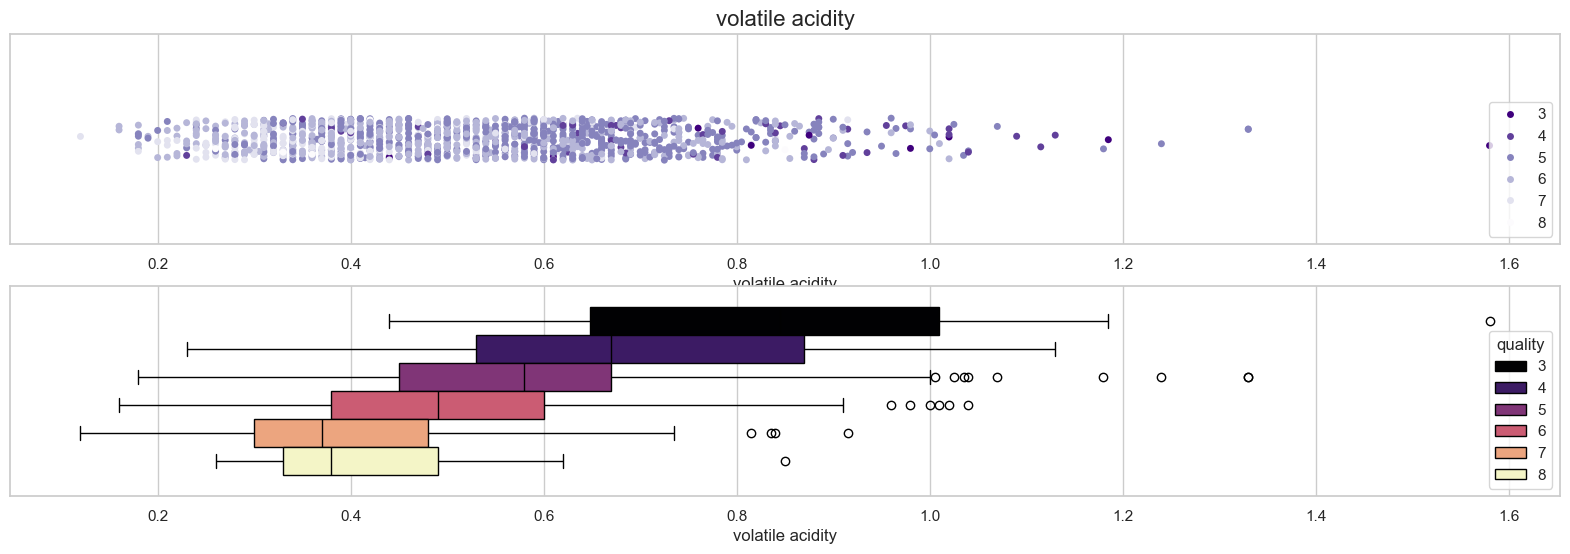

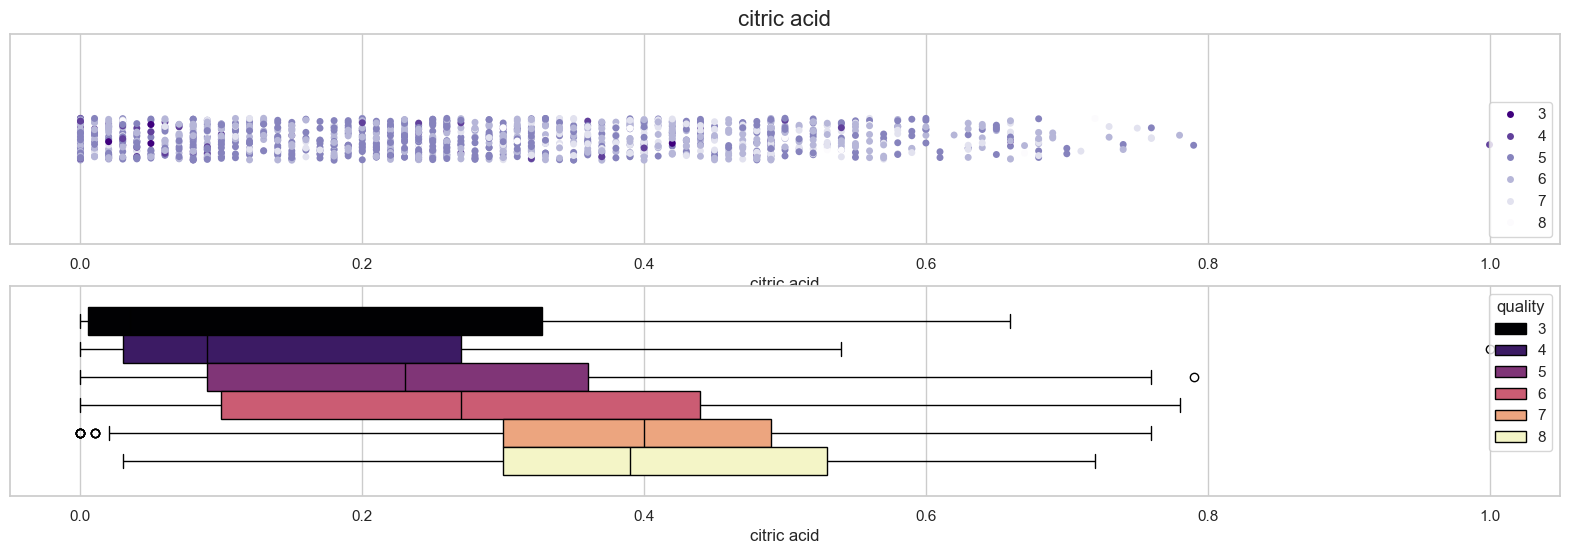

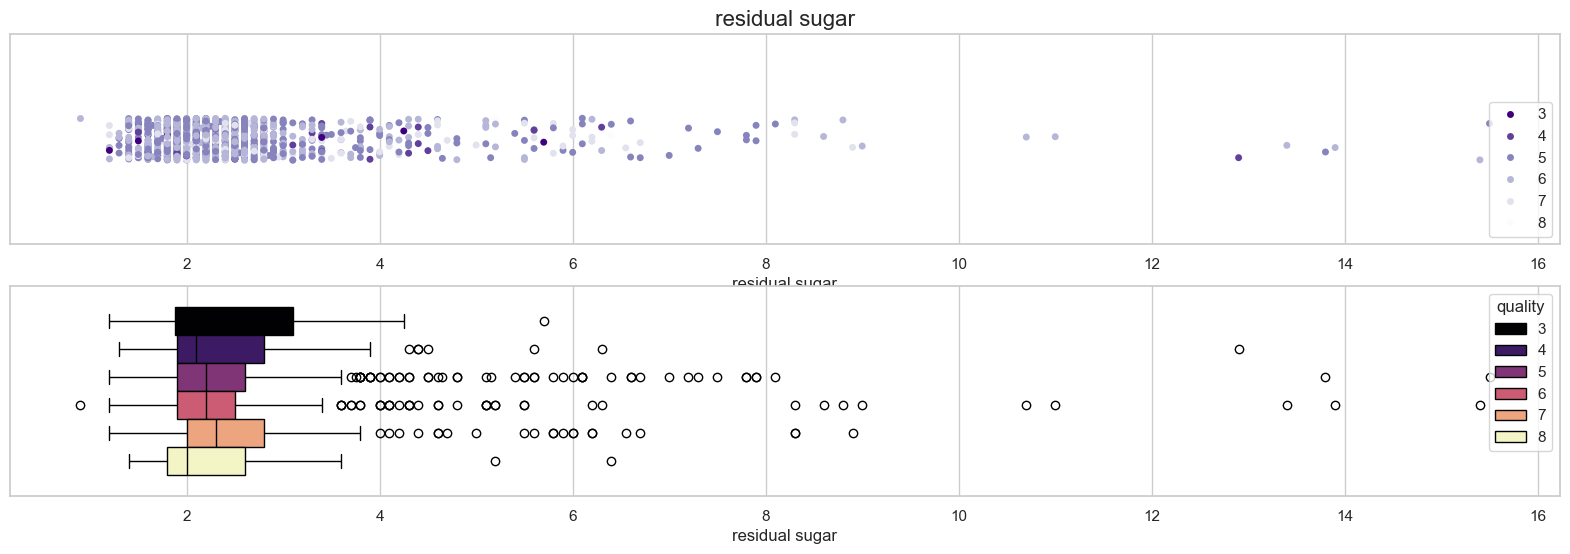

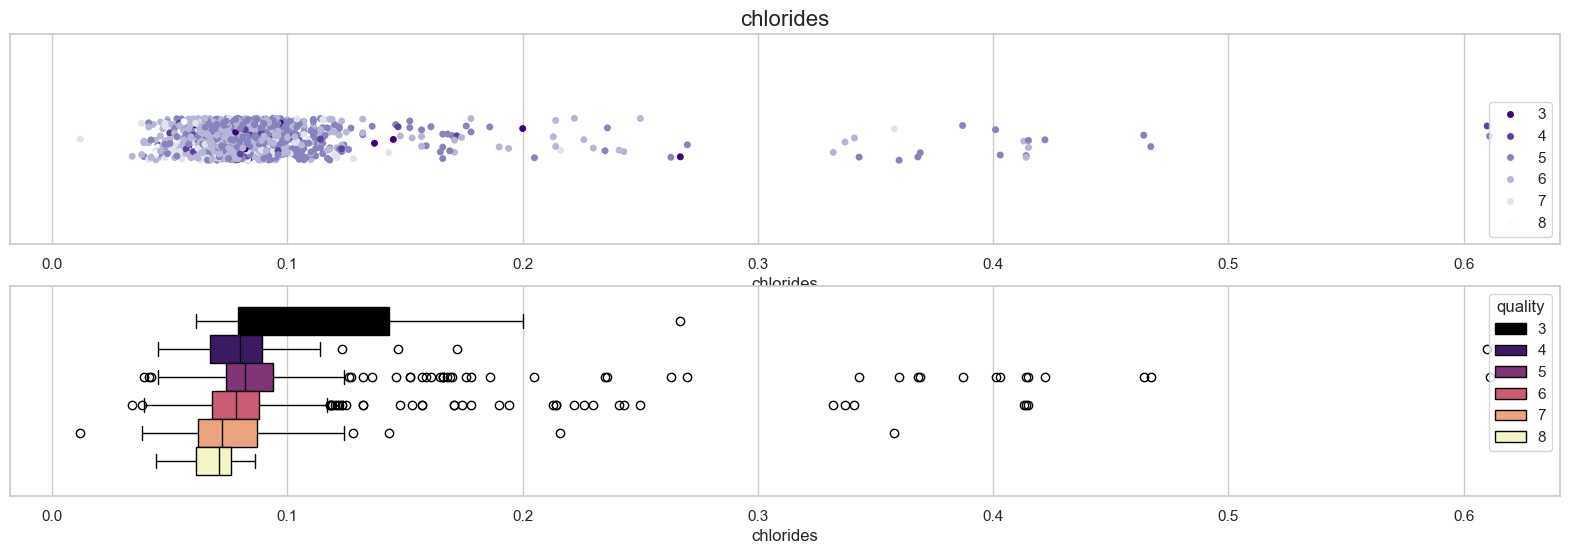

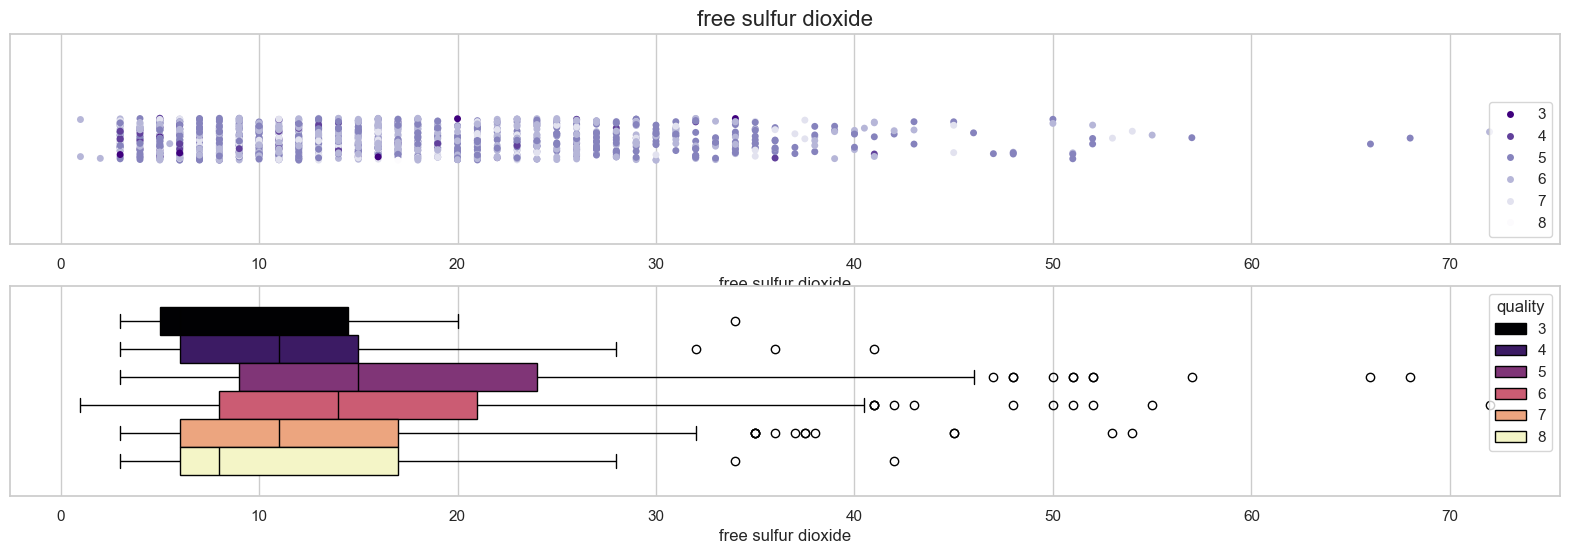

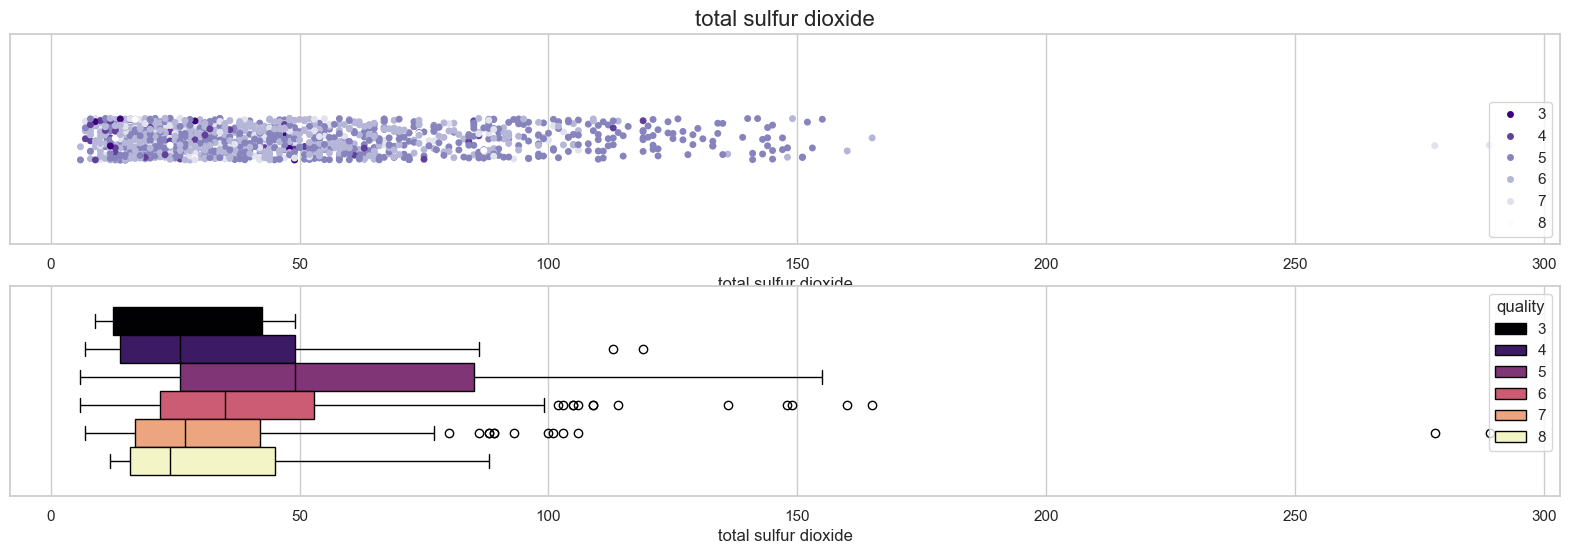

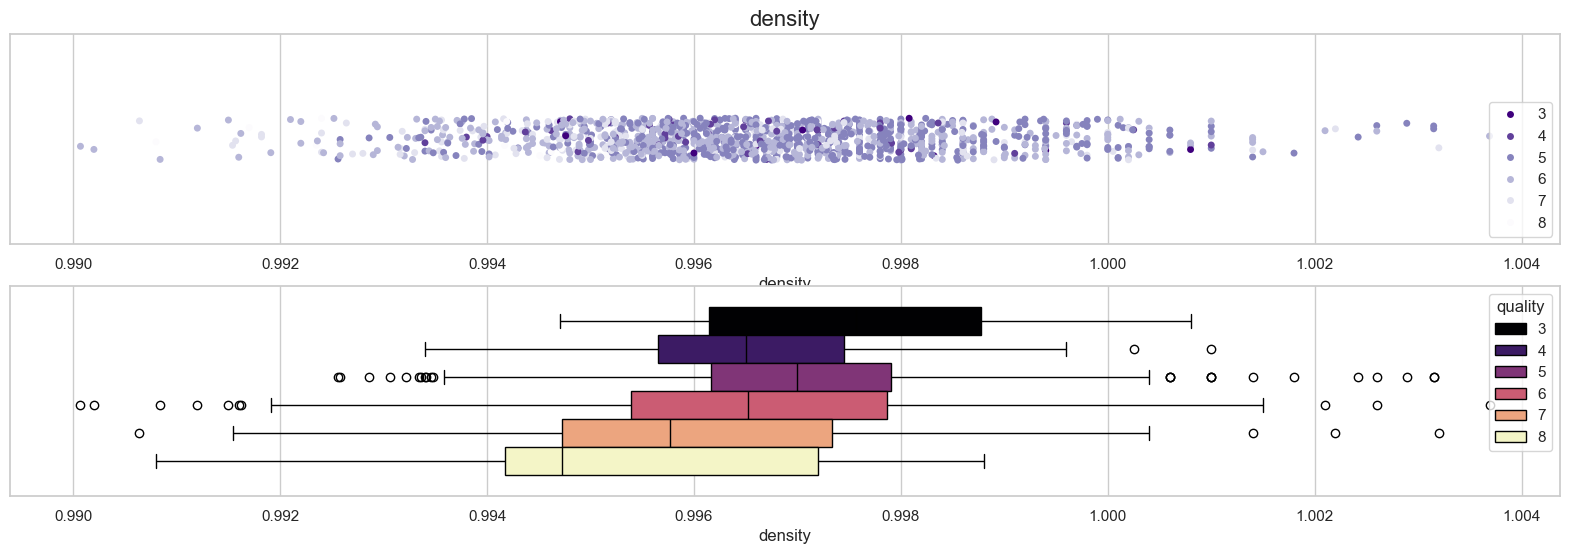

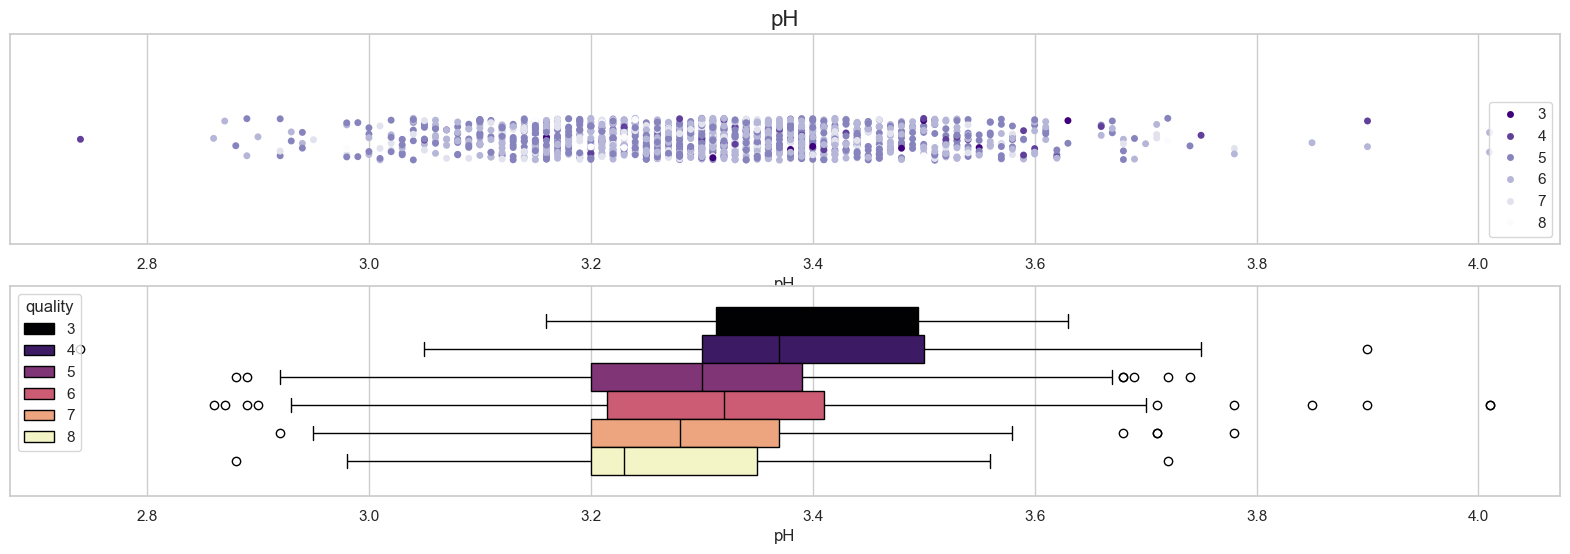

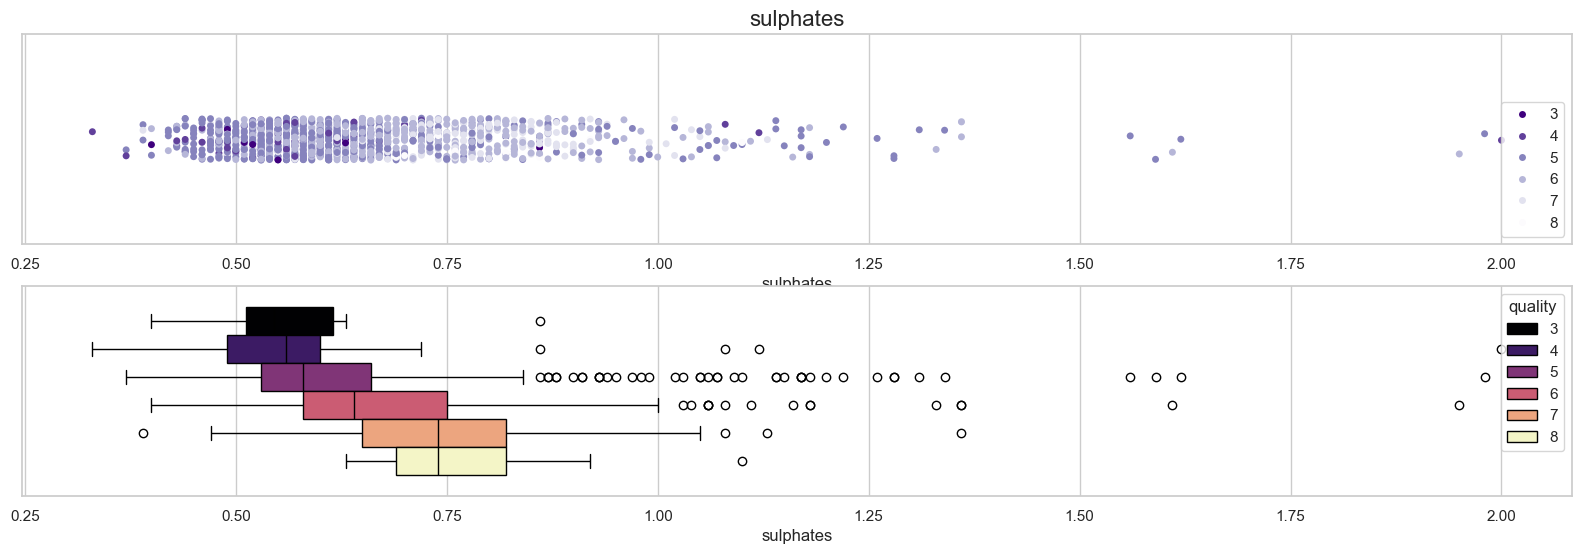

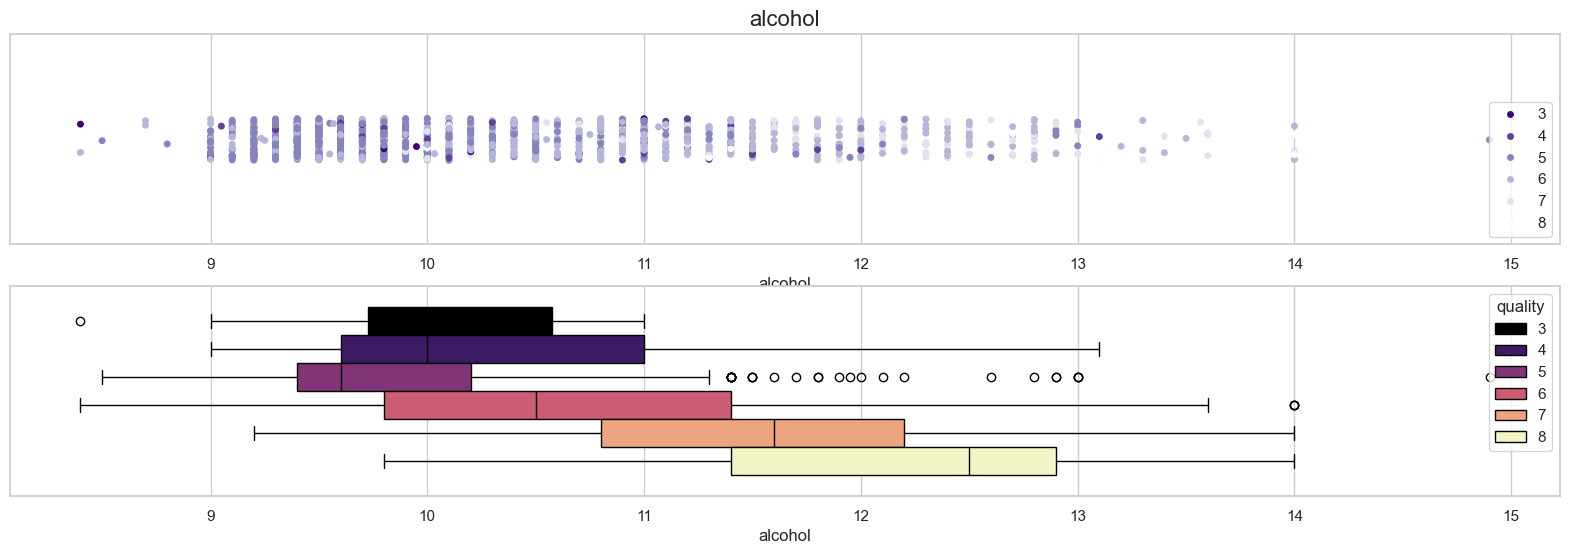

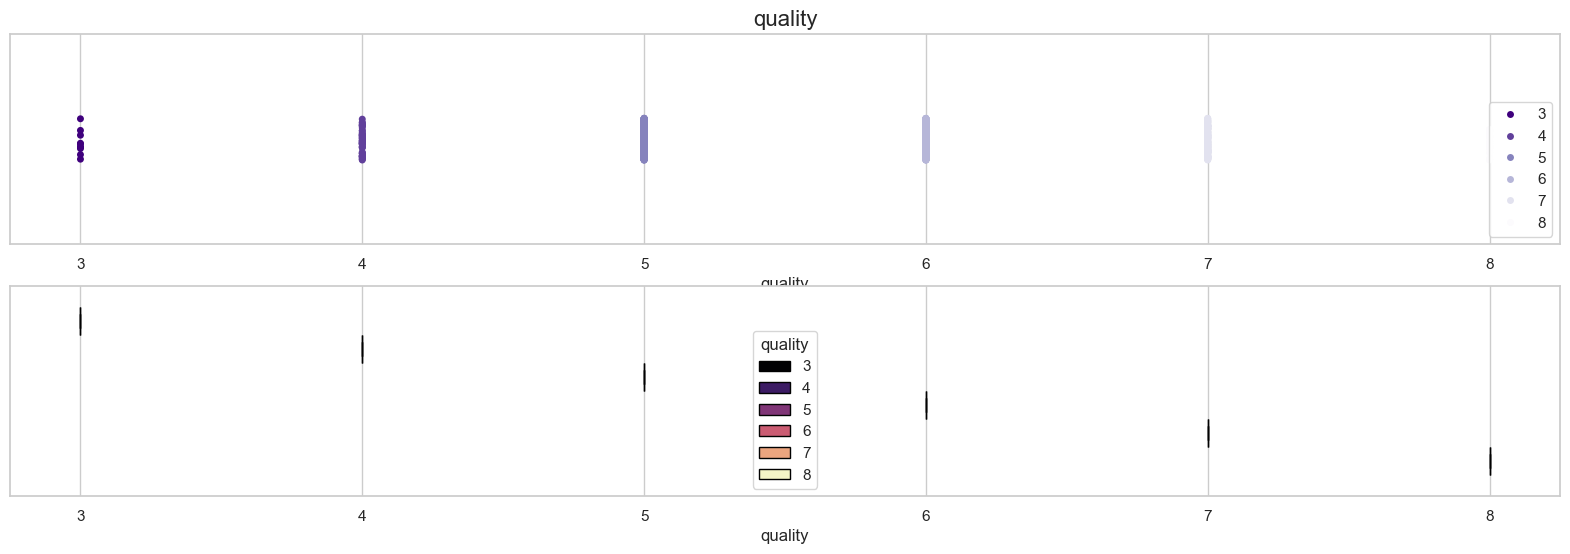

In [304]:
col = list(d.columns)
for i in col:
    fig, axes = plt.subplots(2,1,figsize=(20,6))
    sns.stripplot(d, x = i, hue = 'quality',  palette = 'Purples_r', orient = 'h', ax = axes[0])
    axes[0].set_title(i, fontsize = 16)
    axes[0].legend(loc = 4)
    sns.boxplot(d, hue = 'quality', x = i,  palette = 'magma',  orient = 'h', ax = axes[1])
    plt.show()